In [145]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest

# importing Image class from PIL package
from PIL import Image

projectdata = pd.read_csv('/Users/devi/Documents/Devi/MPS Analytics/Probability and Statistics/PROJECT/Popular Movies TV shows from Prime Videos Netflix version_3 2 2.csv')
#print(projectdata)

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html

In [146]:
#The project is comparison of movies/TV shows in Netflix versus Amazon Prime Video
#Inserting a image representing the analysis

# importing Image class from PIL package
from PIL import Image

#Load the image
img = Image.open('/Users/devi/Documents/Devi/MPS Analytics/Probability and Statistics/PROJECT/Milestone 1/netflix-vs-prime-video.png')

#Get basic details about the image
print(img.format)
print(img.mode)
print(img.size)

#show the image
img.show()


PNG
P
(1200, 345)


In [147]:
# Data cleaning

# IMDb has few rows mentioned as "d;}" which should be NaN
projectdata = projectdata.replace("d;}", np.nan)

# Rotten tomatoes has few rows mentioned as "na" which should be NaN
projectdata = projectdata.replace("na", np.nan)

# Under Genre, there are values under "Anime" genre and "Animation" genre which are same and needs to be replaced with Animation
projectdata = projectdata.replace("Anime", "Animation")


# First column is just row index which is unnamed and not necessary, so we need to remvoe it
projectdata.drop(columns=projectdata.columns[0], axis=1, inplace=True)

projectdata.columns
projectdata.head()

,ID,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video
0,1,Terminator: Dark Fate,2019,18,6.2,81,Action & Adventure,0,1
1,2,Gemini Man,2019,13,5.7,74,Action & Adventure,0,1
2,3,Rambo: Last Blood,2019,18,6.1,72,Action & Adventure,0,1
3,4,The Courier,2019,18,4.9,50,Action & Adventure,0,1
4,5,Crawl,2019,18,6.1,79,Action & Adventure,0,1


In [148]:
# Some movies are listed under multiple genres and are repeated in several rows for each genre. We need merge
# these rows into single one with genre as string delimited by ","
merged_genre_data = projectdata.copy()
merged_genre_data.loc[merged_genre_data['Title'] == "10 Days In Sun City"]

merged_genre_data['Genre'] = merged_genre_data.groupby(['Title', 'Year', 'Rating', 'IMDb', 'Rotten Tomatoes', 'Netflix', 'Amazon Prime Video'], dropna=False)['Genre'].transform(lambda x: ','.join(x))
merged_genre_data = merged_genre_data[['Title', 'Year', 'Rating', 'IMDb', 'Rotten Tomatoes', 'Genre', 'Netflix', 'Amazon Prime Video']].drop_duplicates()

In [149]:
#Same movies are listed in Netflix and Amazon prime video in different entries which needs to be combined
merged_genre_data['Netflix'] = merged_genre_data.groupby(['Title', 'Year', 'Rating', 'IMDb', 'Rotten Tomatoes', 'Genre'], dropna=False)['Netflix'].transform(lambda x: sum(x))
merged_genre_data['Amazon Prime Video'] = merged_genre_data.groupby(['Title', 'Year', 'Rating', 'IMDb', 'Rotten Tomatoes', 'Genre'], dropna=False)['Amazon Prime Video'].transform(lambda x: sum(x))
merged_genre_data = merged_genre_data[['Title', 'Year', 'Rating', 'IMDb', 'Rotten Tomatoes', 'Genre', 'Netflix', 'Amazon Prime Video']].drop_duplicates().reset_index(drop=True)

In [150]:
merged_genre_data.head()

,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video
0,Terminator: Dark Fate,2019,18,6.2,81,Action & Adventure,0,1
1,Gemini Man,2019,13,5.7,74,Action & Adventure,0,1
2,Rambo: Last Blood,2019,18,6.1,72,Action & Adventure,0,1
3,The Courier,2019,18,4.9,50,Action & Adventure,0,1
4,Crawl,2019,18,6.1,79,Action & Adventure,0,1


In [151]:
#Based on Rotten Tomatoes, it can be grouped and categorized into Fresh(greater than 60), Rotten(less than or equal to 60), and No Tomatometer (blank)
merged_genre_data["Rotten Tomatoes"] = pd.to_numeric(merged_genre_data["Rotten Tomatoes"], errors="coerce")

# create a new column named "Category of Rotten Tomatoes" and set it to True if the rating is 60 or above, else False
merged_genre_data["Category of Rotten Tomatoes"] = merged_genre_data["Rotten Tomatoes"] >= 60.0 

# convert the True/False values to "Fresh"/"Rotten"
merged_genre_data["Category of Rotten Tomatoes"] = merged_genre_data["Category of Rotten Tomatoes"].apply(lambda x: "Fresh" if x else "Rotten")

def categorize_rating(rating):
    if pd.isna(rating):
        return "No Tomatometer"
    elif rating >= 60.0:
        return "Fresh"
    else:
        return "Rotten"

merged_genre_data["Category of Rotten Tomatoes"] = merged_genre_data["Rotten Tomatoes"].apply(categorize_rating)

In [152]:
#Based on IMDb, it can be grouped and categorized into Good (7 and above), Average (3-7), and Bad(1-3)
merged_genre_data["IMDb"] = pd.to_numeric(merged_genre_data["IMDb"], errors="coerce")
merged_genre_data["Category of IMDb"] = merged_genre_data["IMDb"] >= 7.0
merged_genre_data["Category of IMDb"] = merged_genre_data["Category of IMDb"].apply(lambda x: "Good" if x else "Bad")

def categorize_rating(rating):
    if pd.isna(rating):
        return "No rating"
    if rating >= 7.0:
        return "Good"
    elif rating < 3.0:
        return "Bad"
    else:
        return "Average"

merged_genre_data["Category of IMDb"] = merged_genre_data["IMDb"].apply(categorize_rating)

In [153]:
merged_genre_data.head()

,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video,Category of Rotten Tomatoes,Category of IMDb
0,Terminator: Dark Fate,2019,18,6.2,81.0,Action & Adventure,0,1,Fresh,Average
1,Gemini Man,2019,13,5.7,74.0,Action & Adventure,0,1,Fresh,Average
2,Rambo: Last Blood,2019,18,6.1,72.0,Action & Adventure,0,1,Fresh,Average
3,The Courier,2019,18,4.9,50.0,Action & Adventure,0,1,Rotten,Average
4,Crawl,2019,18,6.1,79.0,Action & Adventure,0,1,Fresh,Average


In [154]:
merged_genre_data.to_csv("/Users/devi/Documents/Devi/MPS Analytics/Probability and Statistics/PROJECT/cleaned_project_data.csv")

In [155]:
#Descriptive Statistics
merged_genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15238 entries, 0 to 15237
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Title                        15238 non-null  object 
 1   Year                         15238 non-null  int64  
 2   Rating                       6184 non-null   object 
 3   IMDb                         14902 non-null  float64
 4   Rotten Tomatoes              15150 non-null  float64
 5   Genre                        15238 non-null  object 
 6   Netflix                      15238 non-null  int64  
 7   Amazon Prime Video           15238 non-null  int64  
 8   Category of Rotten Tomatoes  15238 non-null  object 
 9   Category of IMDb             15238 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 1.2+ MB


In [156]:
merged_genre_data['IMDb'] = pd.to_numeric(merged_genre_data['IMDb'])
merged_genre_data['Rotten Tomatoes'] = pd.to_numeric(merged_genre_data['Rotten Tomatoes'], errors='coerce')
merged_genre_data.describe()

,Year,IMDb,Rotten Tomatoes,Netflix,Amazon Prime Video
count,15238.000000,14902.000000,15150.000000,15238.000000,15238.000000
mean,2003.378134,5.891907,43.771551,0.181454,0.827405
std,21.203389,1.307138,13.368272,0.385407,0.377909
min,1912.000000,0.000000,10.000000,0.000000,0.000000
25%,2001.000000,5.100000,34.000000,0.000000,1.000000
50%,2012.000000,6.000000,40.000000,0.000000,1.000000
75%,2017.000000,6.800000,51.000000,0.000000,1.000000
max,2021.000000,9.800000,94.000000,1.000000,1.000000


Text(0.5, 1.0, 'Outliers - Movie Release Year - Overall')

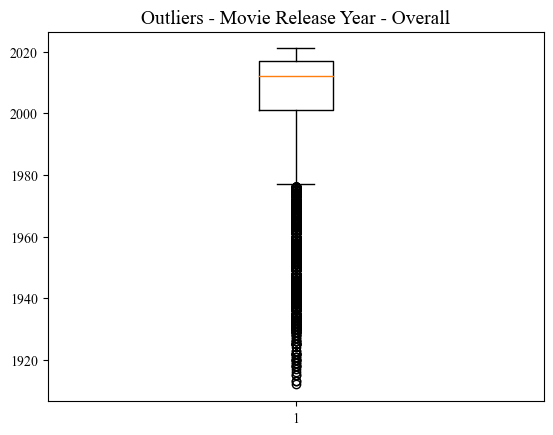

In [157]:
plt.boxplot(merged_genre_data['Year'])
plt.title("Outliers - Movie Release Year - Overall", fontsize=14)

In [158]:
from scipy import stats

# Calculate the z-scores for Year
z_scores = stats.zscore(merged_genre_data['Year'])

# Find the outliers
outliers = merged_genre_data[np.abs(z_scores) > 3]

print("Outliers:", outliers)

Outliers:                                 Title  Year Rating  IMDb  Rotten Tomatoes  \
72     The Private Life of Henry VIII  1933    NaN   7.1             69.0   
363        Chandu on the Magic Island  1935    NaN   4.7             32.0   
468                           Corsair  1931    NaN   5.8             28.0   
493               The Goldwyn Follies  1938    NaN   5.3             28.0   
497                  Song at Midnight  1937    NaN   6.2             45.0   
...                               ...   ...    ...   ...              ...   
12564                   Damaged Lives  1933    NaN   4.4             36.0   
12581        The Hoosier Schoolmaster  1935    NaN   5.7             31.0   
12590                         Secrets  1933    NaN   6.5             41.0   
12599               Fangs of the Wild  1939    NaN   5.1             31.0   
15102                       Thank You  1925    NaN   5.0             32.0   

                                  Genre  Netflix  Amazon Prime Vi

In [159]:
merged_genre_data.count()

Title                          15238
Year                           15238
Rating                          6184
IMDb                           14902
Rotten Tomatoes                15150
Genre                          15238
Netflix                        15238
Amazon Prime Video             15238
Category of Rotten Tomatoes    15238
Category of IMDb               15238
dtype: int64

In [160]:
#Filter details of movie streaming in Netflix
netflix_data = merged_genre_data.loc[merged_genre_data['Netflix'] == 1]
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2765 entries, 46 to 15237
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Title                        2765 non-null   object 
 1   Year                         2765 non-null   int64  
 2   Rating                       1333 non-null   object 
 3   IMDb                         2728 non-null   float64
 4   Rotten Tomatoes              2758 non-null   float64
 5   Genre                        2765 non-null   object 
 6   Netflix                      2765 non-null   int64  
 7   Amazon Prime Video           2765 non-null   int64  
 8   Category of Rotten Tomatoes  2765 non-null   object 
 9   Category of IMDb             2765 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 237.6+ KB


In [161]:
#Describe netflix data
netflix_data.describe()

,Year,IMDb,Rotten Tomatoes,Netflix,Amazon Prime Video
count,2765.000000,2728.000000,2758.000000,2765.0,2765.000000
mean,2013.811573,6.231745,51.583756,1.0,0.048825
std,9.307126,1.111270,14.033797,0.0,0.215540
min,1925.000000,1.500000,10.000000,1.0,0.000000
25%,2013.000000,5.500000,41.000000,1.0,0.000000
50%,2017.000000,6.300000,49.000000,1.0,0.000000
75%,2018.000000,7.000000,61.000000,1.0,0.000000
max,2021.000000,9.000000,93.000000,1.0,1.000000


Text(0.5, 1.0, 'Outliers - Movie Release Year - Netflix')

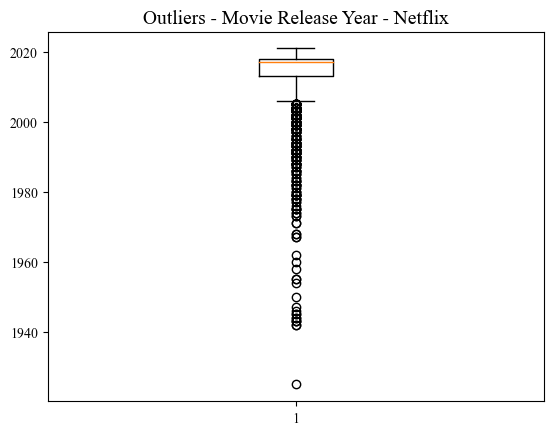

In [162]:
plt.boxplot(netflix_data['Year'])
plt.title("Outliers - Movie Release Year - Netflix", fontsize=14)

In [163]:
from scipy import stats

# Calculate the z-scores for Year
z_scores = stats.zscore(netflix_data['Year'])

# Find the outliers
outliers = netflix_data[np.abs(z_scores) > 3]

print("Outliers:", outliers)

Outliers:                               Title  Year Rating  IMDb  Rotten Tomatoes  \
732                The Longest Yard  1974     18   7.1             74.0   
2837    The 36th Chamber of Shaolin  1978     18   7.7             65.0   
4597   Why We Fight: Prelude to War  1942    NaN   7.0             51.0   
4601              The Negro Soldier  1944    NaN   5.9             44.0   
5566                     San Pietro  1945    NaN   6.6             52.0   
...                             ...   ...    ...   ...              ...   
15074                    Manoranjan  1974    NaN   6.8             42.0   
15087               The Little Wars  1982    NaN   7.1             36.0   
15102                     Thank You  1925    NaN   5.0             32.0   
15161           The Married Couples  1981    NaN   8.0             44.0   
15224              Beirut oh Beirut  1975    NaN   6.7             38.0   

                          Genre  Netflix  Amazon Prime Video  \
732          Crime,Comedy

In [164]:
#Extract only Netflix data and store as CSV file
netflix_data.to_csv("/Users/devi/Documents/Devi/MPS Analytics/Probability and Statistics/PROJECT/netflix_data.csv")

In [165]:
#Filter details of movie streaming in Amazon Prime Video
amazon_prime_video_data = merged_genre_data.loc[merged_genre_data['Amazon Prime Video'] == 1]
amazon_prime_video_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12608 entries, 0 to 12607
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Title                        12608 non-null  object 
 1   Year                         12608 non-null  int64  
 2   Rating                       4908 non-null   object 
 3   IMDb                         12306 non-null  float64
 4   Rotten Tomatoes              12525 non-null  float64
 5   Genre                        12608 non-null  object 
 6   Netflix                      12608 non-null  int64  
 7   Amazon Prime Video           12608 non-null  int64  
 8   Category of Rotten Tomatoes  12608 non-null  object 
 9   Category of IMDb             12608 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 1.1+ MB


In [166]:
#Describe Amazon Prime data
amazon_prime_video_data.describe()

,Year,IMDb,Rotten Tomatoes,Netflix,Amazon Prime Video
count,12608.000000,12306.000000,12525.000000,12608.000000,12608.0
mean,2001.111675,5.821039,42.116487,0.010707,1.0
std,22.339557,1.333556,12.596599,0.102926,0.0
min,1912.000000,0.000000,10.000000,0.000000,1.0
25%,1996.000000,5.000000,34.000000,0.000000,1.0
50%,2011.000000,6.000000,39.000000,0.000000,1.0
75%,2016.000000,6.800000,49.000000,0.000000,1.0
max,2021.000000,9.800000,94.000000,1.000000,1.0


Text(0.5, 1.0, 'Outliers - Movie Release Year - Amazon Prime Video')

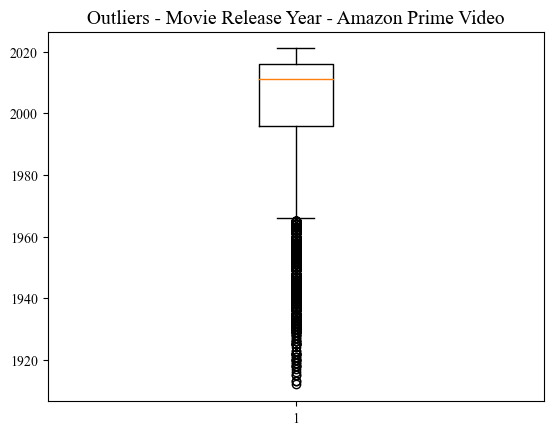

In [167]:
plt.boxplot(amazon_prime_video_data['Year'])
plt.title("Outliers - Movie Release Year - Amazon Prime Video", fontsize=14)

In [168]:
#Amazon Prime Video - Outlier - Year
# Calculate the z-scores for Year
z_scores = stats.zscore(amazon_prime_video_data['Year'])

# Find the outliers
outliers = amazon_prime_video_data[np.abs(z_scores) > 3]

print("Outliers:", outliers)

Outliers:                                 Title  Year Rating  IMDb  Rotten Tomatoes  \
72     The Private Life of Henry VIII  1933    NaN   7.1             69.0   
468                           Corsair  1931    NaN   5.8             28.0   
501                      Judge Priest  1934    NaN   6.3             59.0   
506                Monte Carlo Nights  1934    NaN   5.0             35.0   
707                           Murder!  1930      7   6.4             63.0   
...                               ...   ...    ...   ...              ...   
12502             By Appointment Only  1933    NaN   5.8             34.0   
12520                A Fool There Was  1915    NaN   5.8             55.0   
12549                    Oliver Twist  1933    NaN   4.9             35.0   
12564                   Damaged Lives  1933    NaN   4.4             36.0   
12590                         Secrets  1933    NaN   6.5             41.0   

                                    Genre  Netflix  Amazon Prime 

In [169]:
#Extract only Amazon Prime Video data and store as CSV file
amazon_prime_video_data.to_csv("/Users/devi/Documents/Devi/MPS Analytics/Probability and Statistics/PROJECT/amazon_prime_video_data.csv")

In [170]:
#Filter details of movie streaming in Netflix and Amazon Prime Video
netflix_amazon_prime_video_data = merged_genre_data.loc[(merged_genre_data['Netflix'] == 1) & (merged_genre_data['Amazon Prime Video'] == 1)]
netflix_amazon_prime_video_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 46 to 12578
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Title                        135 non-null    object 
 1   Year                         135 non-null    int64  
 2   Rating                       57 non-null     object 
 3   IMDb                         132 non-null    float64
 4   Rotten Tomatoes              133 non-null    float64
 5   Genre                        135 non-null    object 
 6   Netflix                      135 non-null    int64  
 7   Amazon Prime Video           135 non-null    int64  
 8   Category of Rotten Tomatoes  135 non-null    object 
 9   Category of IMDb             135 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 11.6+ KB


In [171]:
netflix_amazon_prime_video_data.describe()

,Year,IMDb,Rotten Tomatoes,Netflix,Amazon Prime Video
count,135.00000,132.000000,133.000000,135.0,135.0
mean,2005.40000,6.308333,49.909774,1.0,1.0
std,18.51107,1.050121,12.478138,0.0,0.0
min,1942.00000,3.300000,28.000000,1.0,1.0
25%,2004.50000,5.600000,41.000000,1.0,1.0
50%,2012.00000,6.400000,48.000000,1.0,1.0
75%,2017.00000,7.100000,57.000000,1.0,1.0
max,2020.00000,8.500000,93.000000,1.0,1.0


In [172]:
#Extract common movies/tv shows present in Netflix and Amazon Prime Video data and store as CSV file
netflix_amazon_prime_video_data.to_csv("/Users/devi/Documents/Devi/MPS Analytics/Probability and Statistics/PROJECT/netflix_amazon_prime_video_data.csv")

In [173]:
#IMDb Mean
merged_genre_data['IMDb'] = pd.to_numeric(merged_genre_data['IMDb'])
mean_IMDb = merged_genre_data['IMDb'].mean(skipna=True)
print("The mean of IMDb is:", np.round((mean_IMDb),2))

#IMDb Median
median_IMDb = merged_genre_data['IMDb'].median(skipna=True)
print("The median IMDb rating is:", median_IMDb)

#IMDb Standard Deviation
import statistics as st
IMDb_without_missing = merged_genre_data['IMDb'].dropna()
stdev_IMDb = st.stdev(IMDb_without_missing)
print("Standard deviation of IMDb is : ", round(stdev_IMDb, 2))

#IMDb Variance
variance_IMDb = st.variance(IMDb_without_missing)
print("Variance of IMDb is : ", round(variance_IMDb, 2))

The mean of IMDb is: 5.89
The median IMDb rating is: 6.0
Standard deviation of IMDb is :  1.31
Variance of IMDb is :  1.71


In [174]:
#Rotten Tomatoes Mean
merged_genre_data['Rotten Tomatoes'] = pd.to_numeric(merged_genre_data['Rotten Tomatoes'], errors='coerce')
mean_Rotten_Tomatoes = merged_genre_data['Rotten Tomatoes'].mean(skipna=True)
print("The mean of Rotten Tomatoes is:", np.round(mean_Rotten_Tomatoes,2))

#Rotten Tomatoes Median
median_Rotten_Tomatoes = merged_genre_data['Rotten Tomatoes'].median(skipna=True)
print("The median Rotten Tomatoes is:", median_Rotten_Tomatoes)

#IMDb Standard Deviation
import statistics as st
Rotten_Tomatoes_without_missing = merged_genre_data['Rotten Tomatoes'].dropna()
stdev_Rotten_Tomatoes = st.stdev(Rotten_Tomatoes_without_missing)
print("Standard deviation of Rotten Tomatoes is : ", round(stdev_Rotten_Tomatoes, 2))

#IMDb Variance
variance_Rotten_Tomatoes = st.variance(Rotten_Tomatoes_without_missing)
print("Variance of Rotten Tomatoes is : ", round(variance_Rotten_Tomatoes, 2))

The mean of Rotten Tomatoes is: 43.77
The median Rotten Tomatoes is: 40.0
Standard deviation of Rotten Tomatoes is :  13.37
Variance of Rotten Tomatoes is :  178.71


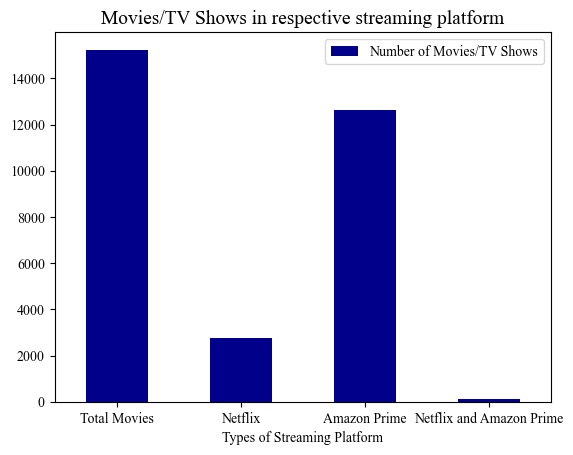

In [175]:
import matplotlib.pyplot as plt

#Visualization
#Number of movies in each stream
plt.rcParams["font.family"] = "Times New Roman"
df = pd.DataFrame({'Types of Streaming Platform':['Total Movies', 'Netflix', 'Amazon Prime', 'Netflix and Amazon Prime'], 'Number of Movies/TV Shows':[15238, 2765, 12608, 135]})
ax = df.plot.bar(x='Types of Streaming Platform', y='Number of Movies/TV Shows', color=['darkblue'], fontsize=10, rot=0)
ax.set_title("Movies/TV Shows in respective streaming platform", fontsize=14)
plt.show()


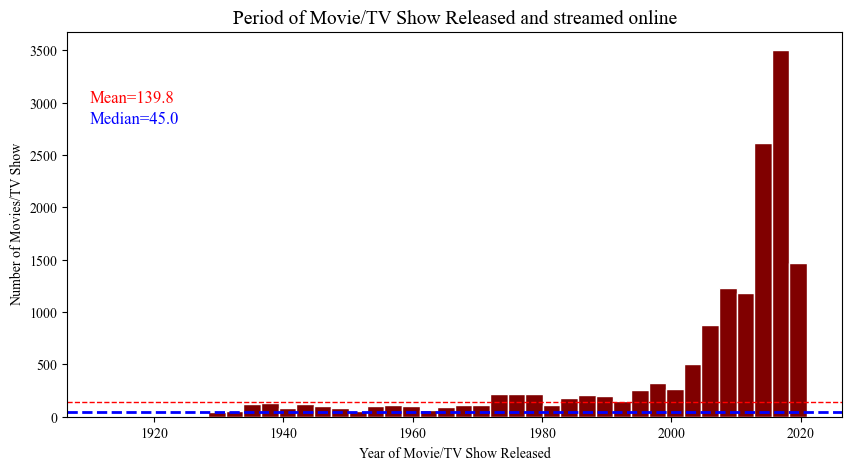

In [176]:
#Movie Release Overall - Year - Histogram
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize = (10, 5))
result = plt.hist(merged_genre_data['Year'], color='maroon',bins=40, edgecolor='white')
# plt.grid(False)
plt.title("Period of Movie/TV Show Released and streamed online",fontsize=14)
plt.xlabel("Year of Movie/TV Show Released")
plt.ylabel("Number of Movies/TV Show")

### Set vertical line for mean
# Get frequency counts for year column
year_counts = merged_genre_data['Year'].value_counts()
# print(year_counts.mean())
# print(year_counts.median())
plt.axhline(year_counts.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axhline(year_counts.median(), color='blue', linestyle='dashed', linewidth=2)
plt.text(1910, 3000, "Mean="+str(np.round(year_counts.mean(),2)), fontsize=12, color='red')
plt.text(1910, 2800, "Median="+str(np.round(year_counts.median(),2)), fontsize=12, color='blue')
plt.show()


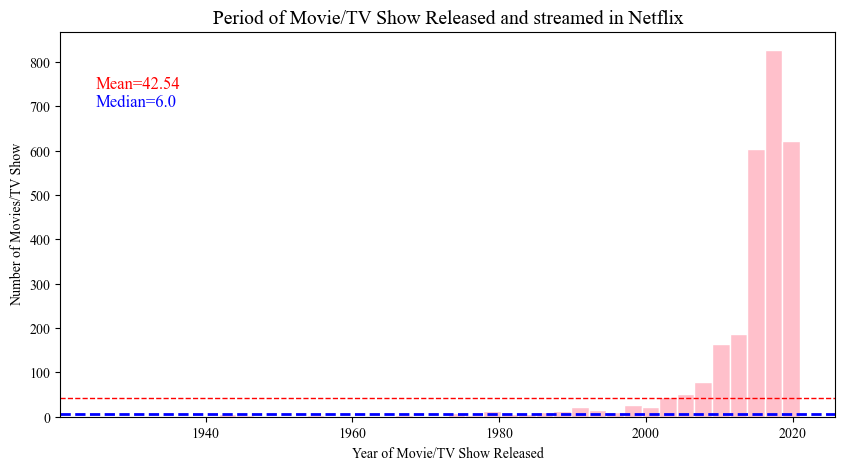

In [177]:
#Movie Release - Netflix - Year - Histogram
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize = (10, 5))
result = plt.hist(netflix_data['Year'], color='pink',bins=40, edgecolor='white')
# plt.grid(False)
plt.title("Period of Movie/TV Show Released and streamed in Netflix", fontsize=14)
plt.xlabel("Year of Movie/TV Show Released")
plt.ylabel("Number of Movies/TV Show")

### Set vertical line for mean
# Get frequency counts for year column
year_counts = netflix_data['Year'].value_counts()
# print(year_counts.mean())
# print(year_counts.median())
plt.axhline(year_counts.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axhline(year_counts.median(), color='blue', linestyle='dashed', linewidth=2)
plt.text(1925, 740, "Mean="+str(np.round(year_counts.mean(),2)), fontsize=12, color='red')
plt.text(1925, 700, "Median="+str(np.round(year_counts.median(),2)), fontsize=12, color='blue')
plt.show()

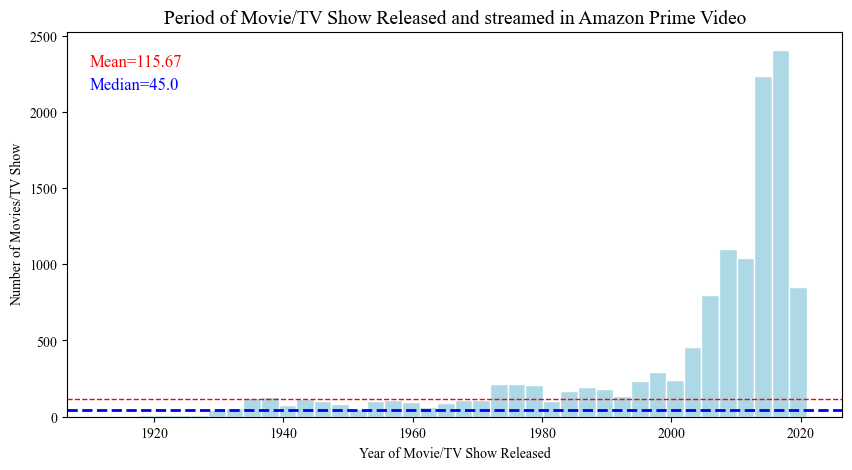

In [178]:
#Movie Release - Amazon Prime Video - Year - Histogram
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize = (10, 5))
result = plt.hist(amazon_prime_video_data['Year'], color='lightblue',bins=40, edgecolor='white')
# plt.grid(False)
plt.title("Period of Movie/TV Show Released and streamed in Amazon Prime Video", fontsize=14)
plt.xlabel("Year of Movie/TV Show Released")
plt.ylabel("Number of Movies/TV Show")

### Set vertical line for mean
# Get frequency counts for year column
year_counts = amazon_prime_video_data['Year'].value_counts()
# print(year_counts.mean())
# print(year_counts.median())
plt.axhline(year_counts.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axhline(year_counts.median(), color='blue', linestyle='dashed', linewidth=2)
plt.text(1910, 2300, "Mean="+str(np.round(year_counts.mean(),2)), fontsize=12, color='red')
plt.text(1910, 2150, "Median="+str(np.round(year_counts.median(),2)), fontsize=12, color='blue')
plt.show()

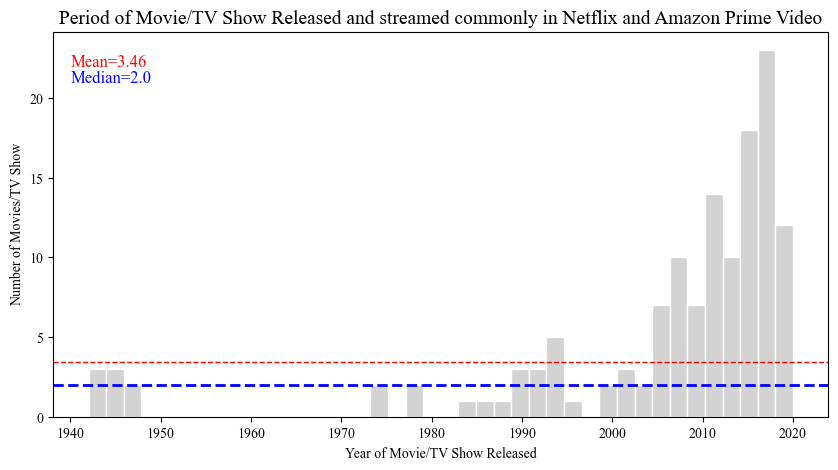

In [179]:
#Movie Release - Netflix and Amazon Prime Video - Year - Histogram
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize = (10, 5))
result = plt.hist(netflix_amazon_prime_video_data['Year'], color='lightgrey',bins=40, edgecolor='white')
# plt.grid(False)
plt.title("Period of Movie/TV Show Released and streamed commonly in Netflix and Amazon Prime Video", fontsize=14)
plt.xlabel("Year of Movie/TV Show Released")
plt.ylabel("Number of Movies/TV Show")
### Set vertical line for mean
# Get frequency counts for year column
year_counts = netflix_amazon_prime_video_data['Year'].value_counts()
# print(year_counts.mean())
# print(year_counts.median())
plt.axhline(year_counts.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axhline(year_counts.median(), color='blue', linestyle='dashed', linewidth=2)
plt.text(1940,22, "Mean="+str(np.round(year_counts.mean(),2)), fontsize=12, color='red')
plt.text(1940,21, "Median="+str(np.round(year_counts.median(),2)), fontsize=12, color='blue')
plt.show()

Text(0.5, 1.0, 'Age rating for content on streaming platforms')

<Figure size 1200x400 with 0 Axes>

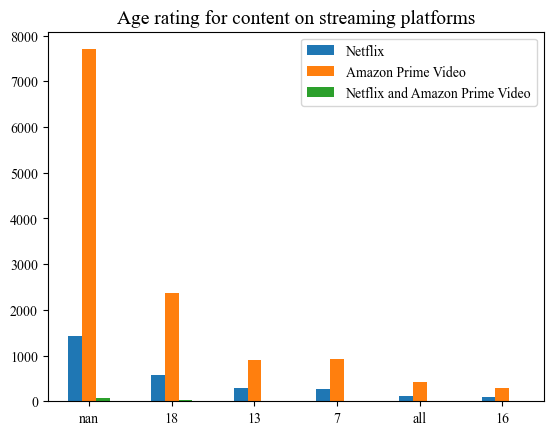

In [180]:
#Age Rating in each platform- Bar Plot

# create subplots for the four barplots
fig = plt.figure(figsize=(12,4))
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,4))
# plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.rcParams["font.family"] = "Times New Roman"

## Creating a pandas series for age rating for netflix, amazon prime, and both
netflix_rating_counts = netflix_data['Rating'].value_counts(dropna=False)
netflix_rating_counts.rename('Netflix', inplace=True)

amazon_prime_rating_counts = amazon_prime_video_data['Rating'].value_counts(dropna=False)
amazon_prime_rating_counts.rename('Amazon Prime Video', inplace=True)

both_counts = netflix_amazon_prime_video_data['Rating'].value_counts(dropna=False)
both_counts.rename('Netflix and Amazon Prime Video', inplace=True)

all_data_counts = pd.concat([netflix_rating_counts, amazon_prime_rating_counts, both_counts], axis=1)
# print(all_data_counts)

## barplot for merged_genre_data
all_data_counts.plot.bar(rot=0)
plt.title("Age rating for content on streaming platforms", fontsize=14)


Text(0.5, 1.0, 'Age ratings distribution of Movies/TV shows for each genre')

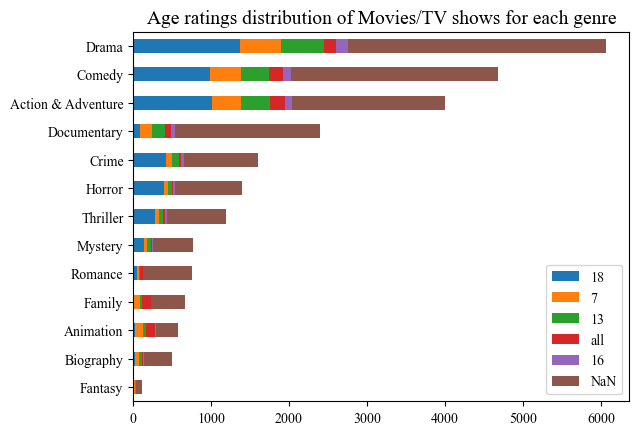

In [181]:
#Age rating distribution for each genre 

## For each genre frequency
# projectdata.head()
ratings = projectdata['Rating'].value_counts().keys().tolist()
# print(ratings)
total_ratings_data = pd.DataFrame()

for rating in ratings:
    rating_df = projectdata.loc[projectdata['Rating'] == rating]['Genre'].value_counts()
    rating_df.rename(rating, inplace=True)
    total_ratings_data = pd.concat([total_ratings_data, rating_df], axis=1)
    
nan_rating_df = projectdata.loc[projectdata['Rating'].isnull()]['Genre'].value_counts()
# print(nan_rating_df)
nan_rating_df.rename('NaN', inplace=True)
total_ratings_data = pd.concat([total_ratings_data, nan_rating_df], axis=1)
    
# print(total_ratings_data)

total_ratings_data.loc[total_ratings_data.sum(axis=1).sort_values().index].plot.barh(stacked=True)
plt.title('Age ratings distribution of Movies/TV shows for each genre', fontsize=14)

Text(0.73, 0.96, ' vs ')

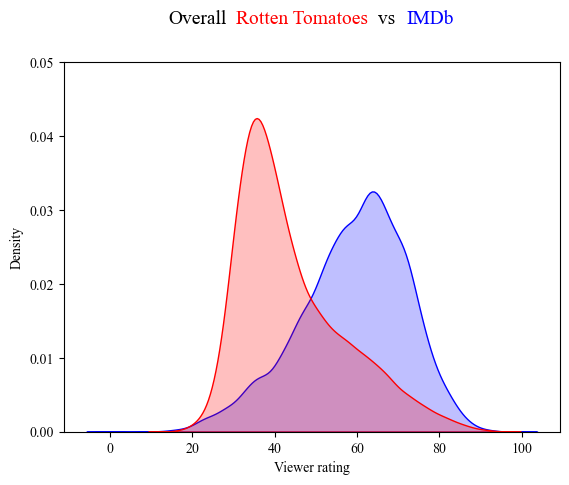

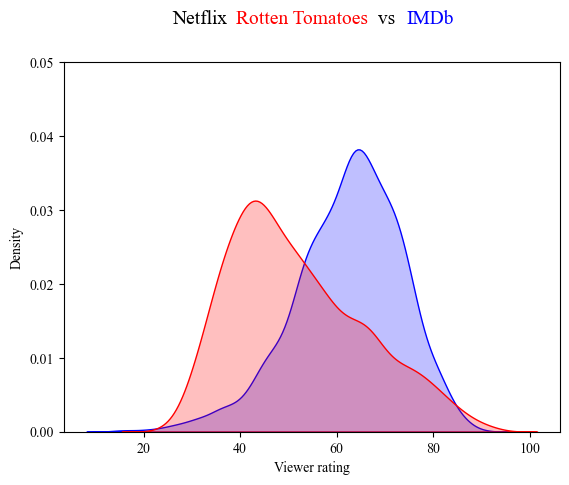

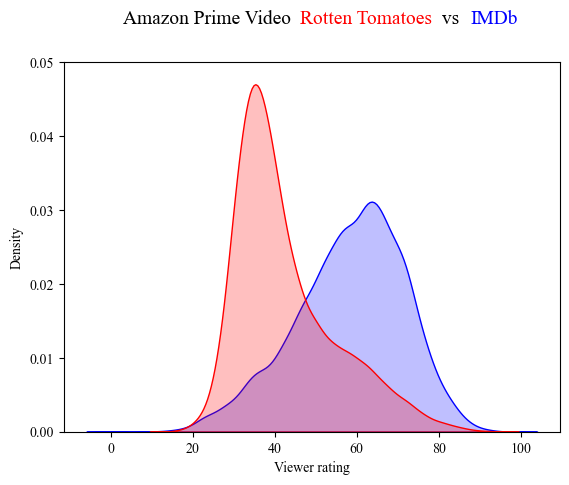

In [182]:
#Density plot – Rotten Tomatoes Vs IMDb - Overall, Netflix, Amazon Prime

import seaborn as sns

cleaned_scores_merged_data = merged_genre_data.copy(deep=True)
cleaned_scores_merged_data = cleaned_scores_merged_data.dropna(subset=['Rotten Tomatoes', 'IMDb'])
cleaned_scores_merged_data['Rotten Tomatoes'] = pd.to_numeric(cleaned_scores_merged_data['Rotten Tomatoes'])
cleaned_scores_merged_data['IMDb'] = pd.to_numeric(cleaned_scores_merged_data['IMDb'])*10

sns.kdeplot(data=cleaned_scores_merged_data, x='IMDb', shade=True, color='blue')
sns.kdeplot(data=cleaned_scores_merged_data, x='Rotten Tomatoes', shade=True, color='red')
plt.xlabel('Viewer rating')
plt.ylim(0,0.050)
plt.figtext(0.38, 0.96, "Overall", fontsize=14, color='black', ha ='right')
plt.figtext(0.60, 0.96, "Rotten Tomatoes", fontsize=14, color='red', ha ='right')
plt.figtext(0.66, 0.96, "IMDb", fontsize=14, color='blue', ha ='left')
plt.figtext(0.63, 0.96, ' vs ', fontsize=14, color='black', ha ='center')
plt.savefig("Netflix Vs Amazon Prime Video")

plt.figure()
sns.kdeplot(data=cleaned_scores_merged_data.loc[cleaned_scores_merged_data['Netflix']==1], x='IMDb', shade=True, color='blue')
sns.kdeplot(data=cleaned_scores_merged_data.loc[cleaned_scores_merged_data['Netflix']==1], x='Rotten Tomatoes', shade=True, color='red')
plt.xlabel('Viewer rating')
plt.ylim(0,0.050)
plt.figtext(0.38, 0.96, "Netflix", fontsize=14, color='black', ha ='right')
plt.figtext(0.60, 0.96, "Rotten Tomatoes", fontsize=14, color='red', ha ='right')
plt.figtext(0.66, 0.96, "IMDb", fontsize=14, color='blue', ha ='left')
plt.figtext(0.63, 0.96, ' vs ', fontsize=14, color='black', ha ='center')


plt.figure()
sns.kdeplot(data=cleaned_scores_merged_data.loc[cleaned_scores_merged_data['Amazon Prime Video']==1], x='IMDb', shade=True, color='blue')
sns.kdeplot(data=cleaned_scores_merged_data.loc[cleaned_scores_merged_data['Amazon Prime Video']==1], x='Rotten Tomatoes', shade=True, color='red')
plt.xlabel('Viewer rating')
plt.ylim(0,0.050)
plt.figtext(0.48, 0.96, "Amazon Prime Video", fontsize=14, color='black', ha ='right')
plt.figtext(0.70, 0.96, "Rotten Tomatoes", fontsize=14, color='red', ha ='right')
plt.figtext(0.76, 0.96, "IMDb", fontsize=14, color='blue', ha ='left')
plt.figtext(0.73, 0.96, ' vs ', fontsize=14, color='black', ha ='center')


Text(0.5, 0.96, ' vs ')

<Figure size 10000x10000 with 0 Axes>

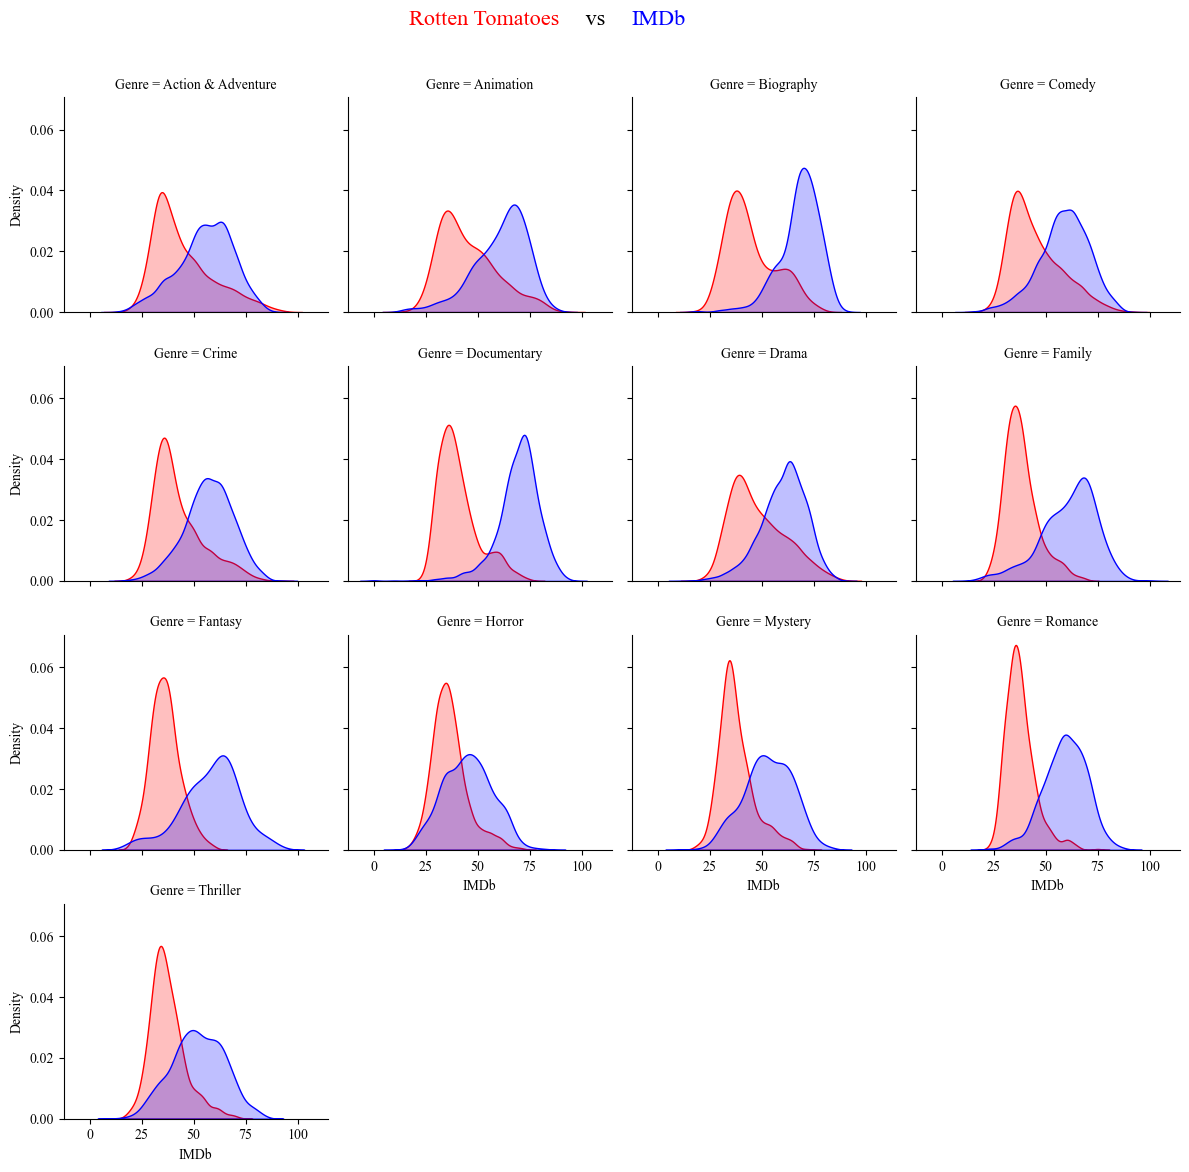

In [183]:
#Histogram– lattice - Breakdown of Rotten Tomatoes for each genre – uncleaned data – Sub-plots 

import seaborn as sns

# Removing NaN in rotten tomatoes and IMDb ratings
cleaned_scores_data = projectdata.copy(deep=True)
cleaned_scores_data = cleaned_scores_data.dropna(subset=['Rotten Tomatoes', 'IMDb'])
cleaned_scores_data['Rotten Tomatoes'] = pd.to_numeric(cleaned_scores_data['Rotten Tomatoes'], errors='coerce')
cleaned_scores_data['IMDb'] = pd.to_numeric(cleaned_scores_data['IMDb'], errors='coerce')*10

plt.figure(figsize=(100,100))

grid = sns.FacetGrid(cleaned_scores_data, col='Genre', col_wrap=4)
grid.map(sns.kdeplot, 'Rotten Tomatoes', shade=True, color='red')
grid.map(sns.kdeplot, 'IMDb', shade=True, color='blue')

grid.fig.subplots_adjust(top=0.9)
plt.figtext(0.47, 0.96, "Rotten Tomatoes", fontsize=16, color='red', ha ='right')
plt.figtext(0.53, 0.96, "IMDb", fontsize=16, color='blue', ha ='left')
plt.figtext(0.50, 0.96, ' vs ', fontsize=16, color='black', ha ='center')

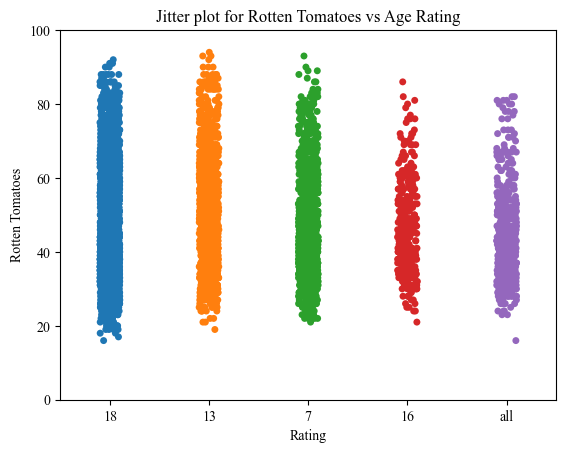

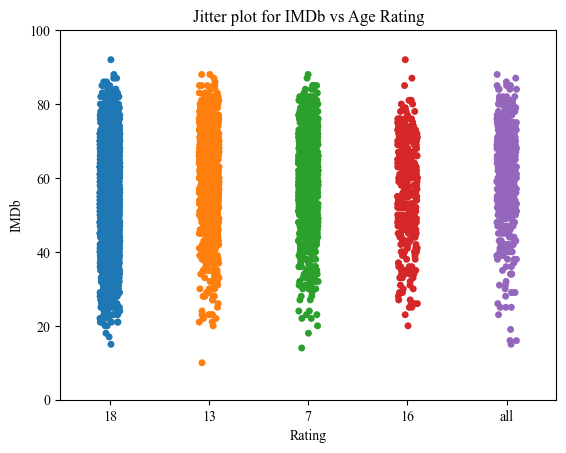

In [184]:
#Jitter Plot - Age Rating vs IMDb and Rotten Tomatoes

plt.rcParams["font.family"] = "Times New Roman"
cleaned_scores_merged_data = merged_genre_data.copy(deep=True)
cleaned_scores_merged_data = cleaned_scores_merged_data.dropna(subset=['Rotten Tomatoes', 'IMDb'])
cleaned_scores_merged_data['Rotten Tomatoes'] = pd.to_numeric(cleaned_scores_merged_data['Rotten Tomatoes'])
cleaned_scores_merged_data['IMDb'] = pd.to_numeric(cleaned_scores_merged_data['IMDb'])*10

# merged_genre_data_rating = merged_genre_data_rating.sort_values('IMDb', ascending=False)
# #print('\n Averages: \n', merged_genre_data_rating.head())
# plt.scatter(merged_genre_data_rating['Rating'], merged_genre_data_rating['IMDb'])


sns.stripplot(y="Rotten Tomatoes", x="Rating", data=cleaned_scores_merged_data)
plt.title("Jitter plot for Rotten Tomatoes vs Age Rating")
plt.ylim(0,100)
plt.show()

sns.stripplot(y="IMDb", x="Rating", data=cleaned_scores_merged_data)
plt.title("Jitter plot for IMDb vs Age Rating")
plt.ylim(0,100)
plt.show()

<Figure size 150000x1000 with 0 Axes>

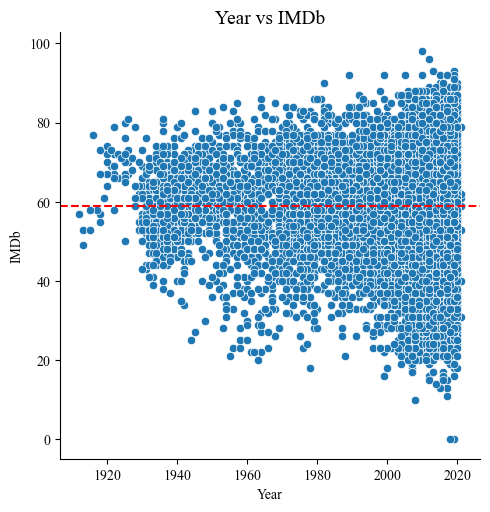

<Figure size 640x480 with 0 Axes>

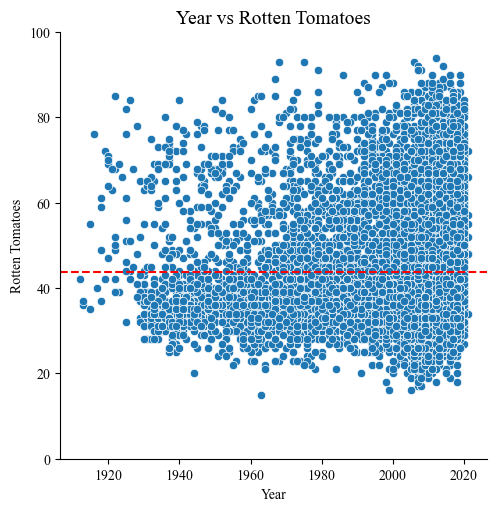

In [185]:
#Scatter Plot - Year vs IMDb vs Rotten Tomatoes


#merged_genre_data.head()
plt.figure(figsize=(1500,10))
sns.relplot(x ="Year", y ="IMDb", data = cleaned_scores_merged_data)
plt.yticks(np.arange(0, 110, step=20))
plt.title('Year vs IMDb', fontsize=14)
# Add an abline at mean y=58.9
plt.axhline(y=58.9, color='r', linestyle='--')
plt.show()



plt.figure()
sns.relplot(x ="Year", y ="Rotten Tomatoes", data = cleaned_scores_merged_data)
plt.yticks(np.arange(0, 110, step=20))
plt.title('Year vs Rotten Tomatoes', fontsize=14)
# Add an abline at mean y=43.77
plt.axhline(y=43.77, color='r', linestyle='--')
plt.show()


In [186]:
#Milestone 2

#Hypothesis Testing 1 

#Claim - xn > xa - Ha
#Opposite - xn <= xa - H0

#Null Hypothesis H0 = The average Rotten Tomatoes rating of movies in Amazon Prime Video is equal to or higher than the average rating of movies in Netflix. 
#Alternate Hypothesis Ha = The average Rotten Tomatoes rating of movies in Netflix is higher than the average rating of movies in Amazon Prime Video. 

#Right tail 


In [187]:
# Randomly select 2000 values from netflix_data and prime_video_data
netflix_sample = netflix_data.sample(n=2000, random_state=41)
amazon_prime_video_sample = amazon_prime_video_data.sample(n=2000, random_state=41)

netflix_sample.describe()

,Year,IMDb,Rotten Tomatoes,Netflix,Amazon Prime Video
count,2000.000000,1976.000000,1995.000000,2000.0,2000.00000
mean,2013.707500,6.216953,51.278697,1.0,0.04800
std,9.544553,1.114408,13.895495,0.0,0.21382
min,1925.000000,1.500000,10.000000,1.0,0.00000
25%,2013.000000,5.500000,41.000000,1.0,0.00000
50%,2017.000000,6.300000,49.000000,1.0,0.00000
75%,2018.000000,7.000000,61.000000,1.0,0.00000
max,2021.000000,9.000000,93.000000,1.0,1.00000


In [188]:
amazon_prime_video_sample.describe()

,Year,IMDb,Rotten Tomatoes,Netflix,Amazon Prime Video
count,2000.000000,1950.000000,1988.000000,2000.000000,2000.0
mean,2001.383500,5.832513,42.091549,0.011500,1.0
std,22.072653,1.343880,12.639744,0.106646,0.0
min,1915.000000,1.300000,10.000000,0.000000,1.0
25%,1997.000000,4.900000,34.000000,0.000000,1.0
50%,2011.000000,6.000000,39.000000,0.000000,1.0
75%,2016.000000,6.800000,49.000000,0.000000,1.0
max,2021.000000,9.200000,88.000000,1.000000,1.0


In [189]:
import scipy.stats

#Average mean of Netflix x1 and Amazon Prime video x2 
x1=51.27
x2=42.09

#Sample standard deviation of Netflix s1 and Amazon Prime video s2 
s1=13.89
s2=12.63

#Count of Netflix n1 and Amazon Prime video n2 
n1=1995
n2=1988

#Even though 2000 sample size were randomly chosen, few did not have any Rotten tomatoes ratings mentioned. Hence, there is a variation in "n" value

In [190]:
from math import sqrt

#Z test is used here as the sample size is more than 30

SE=np.sqrt(((s1*s1)/n1)+((s2*s2)/n2))
print("Standard Error %.5f"%SE)

z_stat = (x1-x2)-0/SE
print("Z_Stat is %.5f"%z_stat)

#find p-value for right tail 
p_value = scipy.stats.norm.sf(abs(z_stat))
print("P value is %.5f"%p_value)

#When significance level is 0.05
if p_value < 0.05:
    print("Reject the null hypothesis. Therefore, the average Rotten Tomatoes rating of movies in Netflix is higher than the average rating of movies in Amazon Prime Video.")
else:
    print("Fail to reject the null hypothesis. We do not have sufficient evidence to reject that the average Rotten Tomatoes rating of movies in Netflix is higher than the average rating of movies in Amazon Prime Video.")


Standard Error 0.42065
Z_Stat is 9.18000
P value is 0.00000
Reject the null hypothesis. Therefore, the average Rotten Tomatoes rating of movies in Netflix is higher than the average rating of movies in Amazon Prime Video.


In [191]:
#Hypothesis Testing 2 

#IMDb Rating

#Claim - xn > xa - Ha
#Opposite - xn <= xa - H0

#Null Hypothesis H0 = The average IMDb rating of movies in Amazon Prime Video is equal to or higher than the average IMDb rating of movies in Netflix. 
#Alternate Hypothesis Ha = The average IMDb rating of movies in Netflix is higher than the average IMDb rating of movies in Amazon Prime Video. 

#Right tail 

import scipy.stats

#Average mean of Netflix x1 and Amazon Prime video x2 
x1=6.21
x2=5.83

#Sample standard deviation of Netflix s1 and Amazon Prime video s2 
s1=1.11
s2=1.34

#Count of Netflix n1 and Amazon Prime video n2 
n1=1976
n2=1950

In [192]:
from math import sqrt

#Z test is used here as the sample size is more than 30

SE=np.sqrt(((s1*s1)/n1)+((s2*s2)/n2))
print("Standard Error %.5f"%SE)

z_stat = (x1-x2)-0/SE
print("Z_Stat is %.5f"%z_stat)

#find p-value for right tail 
p_value = scipy.stats.norm.sf(abs(z_stat))
print("P value is %.5f"%p_value)

#When significance level is 0.05
if p_value < 0.05:
    print("Reject the null hypothesis. Therefore, The average IMDb rating of movies in Netflix is higher than the average IMDb rating of movies in Amazon Prime Video")
else:
    print("Fail to reject the null hypothesis. We do not have sufficient evidence to reject that the average IMDb rating of movies in Amazon Prime Video is equal to or higher than the average IMDb rating of movies in Netflix.") 

Standard Error 0.03930
Z_Stat is 0.38000
P value is 0.35197
Fail to reject the null hypothesis. We do not have sufficient evidence to reject that the average IMDb rating of movies in Amazon Prime Video is equal to or higher than the average IMDb rating of movies in Netflix.


In [193]:
#Based on Rotten Tomatoes, it can be grouped and categorized into Fresh(greater than 60), Rotten(less than or equal to 60), and No Tomatometer (blank)
merged_genre_data["Rotten Tomatoes"] = pd.to_numeric(merged_genre_data["Rotten Tomatoes"], errors="coerce")

# create a new column named "Category of Rotten Tomatoes" and set it to True if the rating is 60 or above, else False
merged_genre_data["Category of Rotten Tomatoes"] = merged_genre_data["Rotten Tomatoes"] >= 60.0 

# convert the True/False values to "Fresh"/"Rotten"
merged_genre_data["Category of Rotten Tomatoes"] = merged_genre_data["Category of Rotten Tomatoes"].apply(lambda x: "Fresh" if x else "Rotten")

def categorize_rating(rating):
    if pd.isna(rating):
        return "No Tomatometer"
    elif rating >= 60.0:
        return "Fresh"
    else:
        return "Rotten"

merged_genre_data["Category of Rotten Tomatoes"] = merged_genre_data["Rotten Tomatoes"].apply(categorize_rating)

In [194]:
#Based on IMDb, it can be grouped and categorized into Good (7 and above), Average (3-7), and Bad(1-3)
merged_genre_data["IMDb"] = pd.to_numeric(merged_genre_data["IMDb"], errors="coerce")
merged_genre_data["Category of IMDb"] = merged_genre_data["IMDb"] >= 7.0
merged_genre_data["Category of IMDb"] = merged_genre_data["Category of IMDb"].apply(lambda x: "Good" if x else "Bad")

def categorize_rating(rating):
    if pd.isna(rating):
        return "No rating"
    if rating >= 7.0:
        return "Good"
    elif rating < 3.0:
        return "Bad"
    else:
        return "Average"

merged_genre_data["Category of IMDb"] = merged_genre_data["IMDb"].apply(categorize_rating)

In [195]:
merged_genre_data.head()

,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video,Category of Rotten Tomatoes,Category of IMDb
0,Terminator: Dark Fate,2019,18,6.2,81.0,Action & Adventure,0,1,Fresh,Average
1,Gemini Man,2019,13,5.7,74.0,Action & Adventure,0,1,Fresh,Average
2,Rambo: Last Blood,2019,18,6.1,72.0,Action & Adventure,0,1,Fresh,Average
3,The Courier,2019,18,4.9,50.0,Action & Adventure,0,1,Rotten,Average
4,Crawl,2019,18,6.1,79.0,Action & Adventure,0,1,Fresh,Average


In [196]:
netflix_data = merged_genre_data.loc[merged_genre_data['Netflix'] == 1]
netflix_data.head()

,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video,Category of Rotten Tomatoes,Category of IMDb
46,Hulk Vs.,2009,13,7.0,73.0,"Animation,Action & Adventure",1,1,Fresh,Good
50,Delirium,2018,18,5.7,53.0,Animation,1,1,Rotten,Average
159,Don,2006,13,7.2,62.0,"Crime,Action & Adventure",1,1,Fresh,Good
252,Blue Jay,2016,NaN,7.3,76.0,Drama,1,1,Fresh,Good
264,Raising the Bar,2017,7,5.6,46.0,Drama,1,1,Rotten,Average


In [197]:
amazon_prime_video_data = merged_genre_data.loc[merged_genre_data['Amazon Prime Video'] == 1]
amazon_prime_video_data.head()

,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video,Category of Rotten Tomatoes,Category of IMDb
0,Terminator: Dark Fate,2019,18,6.2,81.0,Action & Adventure,0,1,Fresh,Average
1,Gemini Man,2019,13,5.7,74.0,Action & Adventure,0,1,Fresh,Average
2,Rambo: Last Blood,2019,18,6.1,72.0,Action & Adventure,0,1,Fresh,Average
3,The Courier,2019,18,4.9,50.0,Action & Adventure,0,1,Rotten,Average
4,Crawl,2019,18,6.1,79.0,Action & Adventure,0,1,Fresh,Average


Rotten            2002
Fresh              756
No Tomatometer       7
Name: Category of Rotten Tomatoes, dtype: int64


Text(0.5, 1.0, 'Category of Rotten Tomatoes for movies present in Netflix')

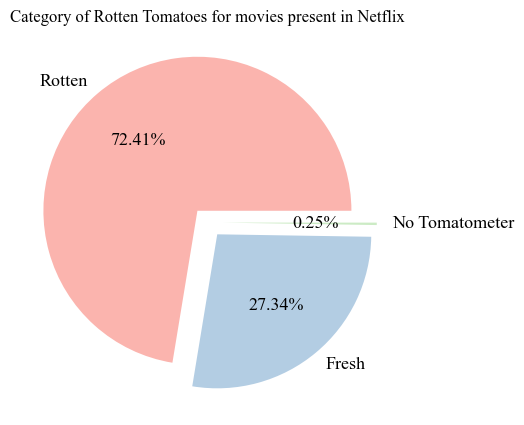

In [198]:
netflix_rotten_tomato_count = netflix_data['Category of Rotten Tomatoes'].value_counts()
print(netflix_rotten_tomato_count)
plt.rcParams["font.family"] = "Times New Roman"
kwargs = dict(startangle=0,
    colors=[plt.cm.Pastel1(i) for i in range(3)],
    fontsize=13,
    explode=(0.1,0.1,0.1),
    autopct='%1.2f%%',
    figsize=(5,5),
    label='')
netflix_rotten_tomato_count.plot.pie(**kwargs)
plt.title('Category of Rotten Tomatoes for movies present in Netflix')

Rotten            11081
Fresh              1444
No Tomatometer       83
Name: Category of Rotten Tomatoes, dtype: int64


Text(0.5, 1.0, 'Category of Rotten Tomatoes for movies present in Amazon Prime Video')

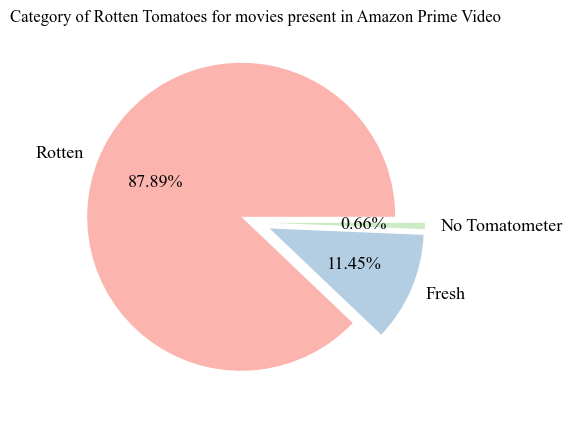

In [199]:
amazonprimevideo_rotten_tomato_count = amazon_prime_video_data['Category of Rotten Tomatoes'].value_counts()
print(amazonprimevideo_rotten_tomato_count)
plt.rcParams["font.family"] = "Times New Roman"
kwargs = dict(startangle=0,
    colors=[plt.cm.Pastel1(i) for i in range(3)],
    fontsize=13,
    explode=(0.1,0.1,0.1),
    autopct='%1.2f%%',
    figsize=(5,5),
    label='')
amazonprimevideo_rotten_tomato_count.plot.pie(**kwargs)
plt.title('Category of Rotten Tomatoes for movies present in Amazon Prime Video')

Average      1962
Good          744
No rating      37
Bad            22
Name: Category of IMDb, dtype: int64


Text(0.5, 1.0, 'Category of IMDb for movies present in Netflix')

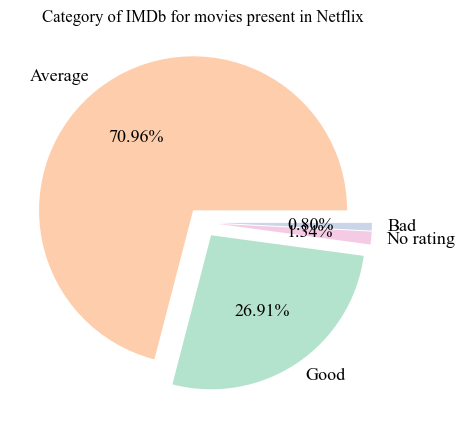

In [200]:
netflix_IMDb_count = netflix_data['Category of IMDb'].value_counts()
print(netflix_IMDb_count)

kwargs = dict(startangle=0,
    fontsize=13,
    explode=(0.1,0.1,0.1,0.1),
    autopct='%1.2f%%',
    figsize=(5,5),
    label='')
IMDb_category_colors = {
    "Good": plt.cm.Pastel2(0),
    "Average": plt.cm.Pastel2(1),
    "Bad": plt.cm.Pastel2(2),
    "No rating": plt.cm.Pastel2(3),
}
kwargs['colors'] = [IMDb_category_colors[index] for index in netflix_IMDb_count.index]
netflix_IMDb_count.plot.pie(**kwargs)
plt.title('Category of IMDb for movies present in Netflix')

Average      9414
Good         2551
Bad           341
No rating     302
Name: Category of IMDb, dtype: int64


Text(0.5, 1.0, 'Category of IMDb for movies present in Amazon Prime Video')

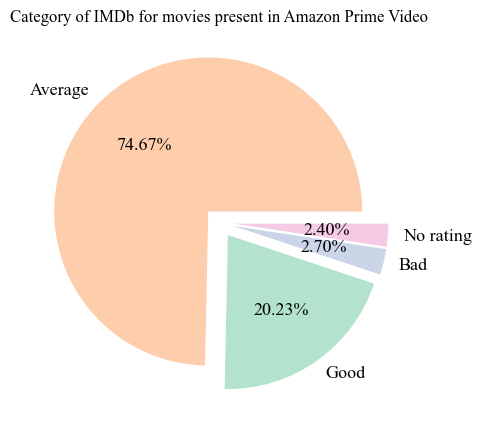

In [201]:
amazonprimevideo_IMDb_count = amazon_prime_video_data['Category of IMDb'].value_counts()
print(amazonprimevideo_IMDb_count)

kwargs = dict(startangle=0,
    fontsize=13,
    explode=(0.1,0.1,0.1,0.1),
    autopct='%1.2f%%',
    figsize=(5,5),
    label='')
IMDb_category_colors = {
    "Good": plt.cm.Pastel2(0),
    "Average": plt.cm.Pastel2(1),
    "Bad": plt.cm.Pastel2(2),
    "No rating": plt.cm.Pastel2(3),
}
kwargs['colors'] = [IMDb_category_colors[index] for index in amazonprimevideo_IMDb_count.index]
amazonprimevideo_IMDb_count.plot.pie(**kwargs)
plt.title('Category of IMDb for movies present in Amazon Prime Video')

In [202]:
#Based on Rotten Tomatoes, it can be grouped and categorized into Fresh(greater than 60), Rotten(less than or equal to 60), and No Tomatometer (blank)
projectdata["Rotten Tomatoes"] = pd.to_numeric(projectdata["Rotten Tomatoes"], errors="coerce")

# create a new column named "Category of Rotten Tomatoes" and set it to True if the rating is 60 or above, else False
projectdata["Category of Rotten Tomatoes"] = projectdata["Rotten Tomatoes"] >= 60.0 

# convert the True/False values to "Fresh"/"Rotten"
projectdata["Category of Rotten Tomatoes"] = projectdata["Category of Rotten Tomatoes"].apply(lambda x: "Fresh" if x else "Rotten")

def categorize_rating(rating):
    if pd.isna(rating):
        return "No Tomatometer"
    elif rating >= 60.0:
        return "Fresh"
    else:
        return "Rotten"

projectdata["Category of Rotten Tomatoes"] = projectdata["Rotten Tomatoes"].apply(categorize_rating)


In [203]:
#Based on IMDb, it can be grouped and categorized into Good (7 and above), Average (3-7), and Bad(1-3)
projectdata["IMDb"] = pd.to_numeric(projectdata["IMDb"], errors="coerce")
projectdata["Category of IMDb"] = projectdata["IMDb"] >= 7.0
projectdata["Category of IMDb"] = projectdata["Category of IMDb"].apply(lambda x: "Good" if x else "Bad")

def categorize_rating(rating):
    if pd.isna(rating):
        return "No rating"
    if rating >= 7.0:
        return "Good"
    elif rating < 3.0:
        return "Bad"
    else:
        return "Average"

projectdata["Category of IMDb"] = projectdata["IMDb"].apply(categorize_rating)
projectdata.head()

,ID,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video,Category of Rotten Tomatoes,Category of IMDb
0,1,Terminator: Dark Fate,2019,18,6.2,81.0,Action & Adventure,0,1,Fresh,Average
1,2,Gemini Man,2019,13,5.7,74.0,Action & Adventure,0,1,Fresh,Average
2,3,Rambo: Last Blood,2019,18,6.1,72.0,Action & Adventure,0,1,Fresh,Average
3,4,The Courier,2019,18,4.9,50.0,Action & Adventure,0,1,Rotten,Average
4,5,Crawl,2019,18,6.1,79.0,Action & Adventure,0,1,Fresh,Average


In [204]:
projectdata.to_csv("/Users/devi/Documents/Devi/MPS Analytics/Probability and Statistics/PROJECT/project_data.csv")

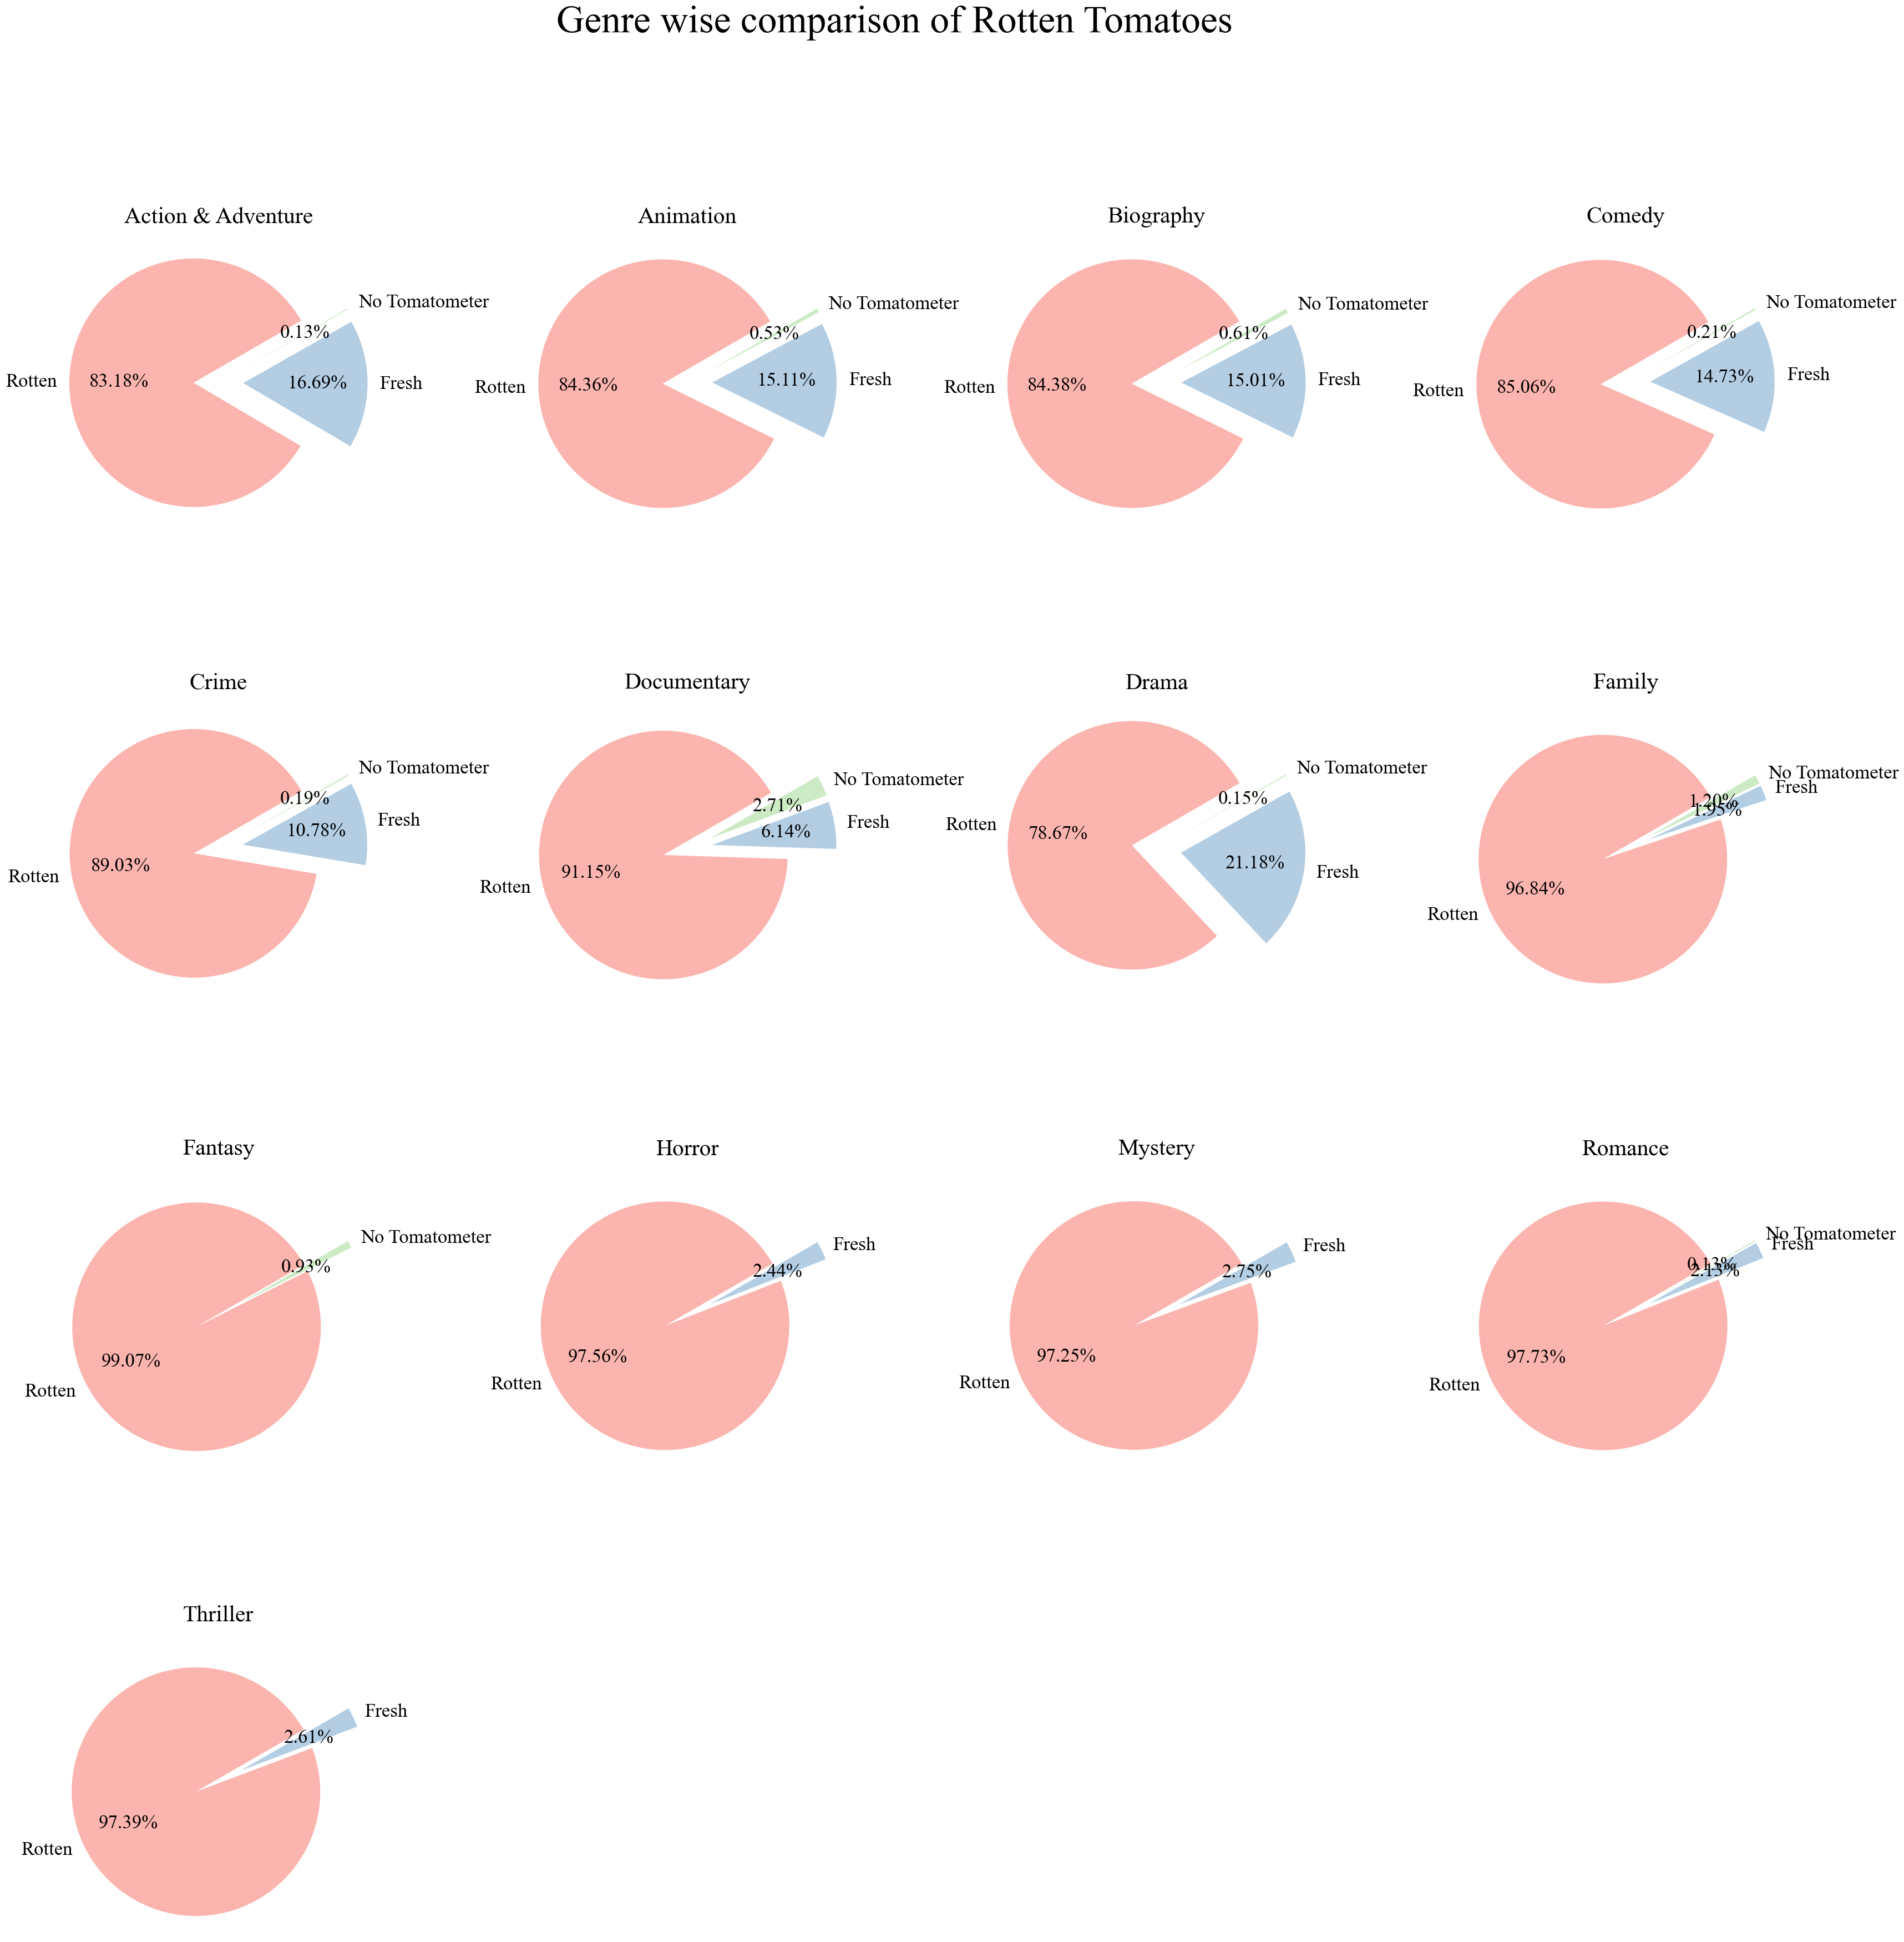

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data by Genre and Category of Rotten Tomatoes
genre_grouped_projectdata = projectdata.groupby("Genre").apply(lambda x: x['Category of Rotten Tomatoes'].value_counts())
genre_grouped_projectdata = genre_grouped_projectdata.reset_index()
genre_grouped_projectdata.rename(columns={"Category of Rotten Tomatoes": "Frequency", "level_1": "Category of Rotten Tomatoes"}, inplace=True)

fig, axes = plt.subplots(4, 4, figsize=(40, 40))
[axi.set_axis_off() for axi in axes.ravel()]
plt.subplots_adjust(wspace=0.5, hspace=0.5)


fig.suptitle('Genre wise comparison of Rotten Tomatoes', fontsize=50)

kwargs = dict(startangle=30,
    fontsize=25,
    autopct='%1.2f%%')

rotten_tomatoes_category_colors = {
    "Rotten": plt.cm.Pastel1(0),
    "Fresh": plt.cm.Pastel1(1),
    "No Tomatometer": plt.cm.Pastel1(2)
}


for idx, genre in enumerate(projectdata['Genre'].unique()):
    genre_data = projectdata[projectdata['Genre'] == genre]
    genre_rotten_tomatoes_category_count = genre_data['Category of Rotten Tomatoes'].value_counts()
    i, j = [idx//4, idx%4]
    
    kwargs['explode'] = [0.2]*len(genre_rotten_tomatoes_category_count)
    kwargs['colors'] = [rotten_tomatoes_category_colors[index] for index in genre_rotten_tomatoes_category_count.index]
    genre_rotten_tomatoes_category_count.plot.pie(ax=axes[i, j] ,**kwargs)
    axes[i, j].set_title(genre, fontsize=30)
    

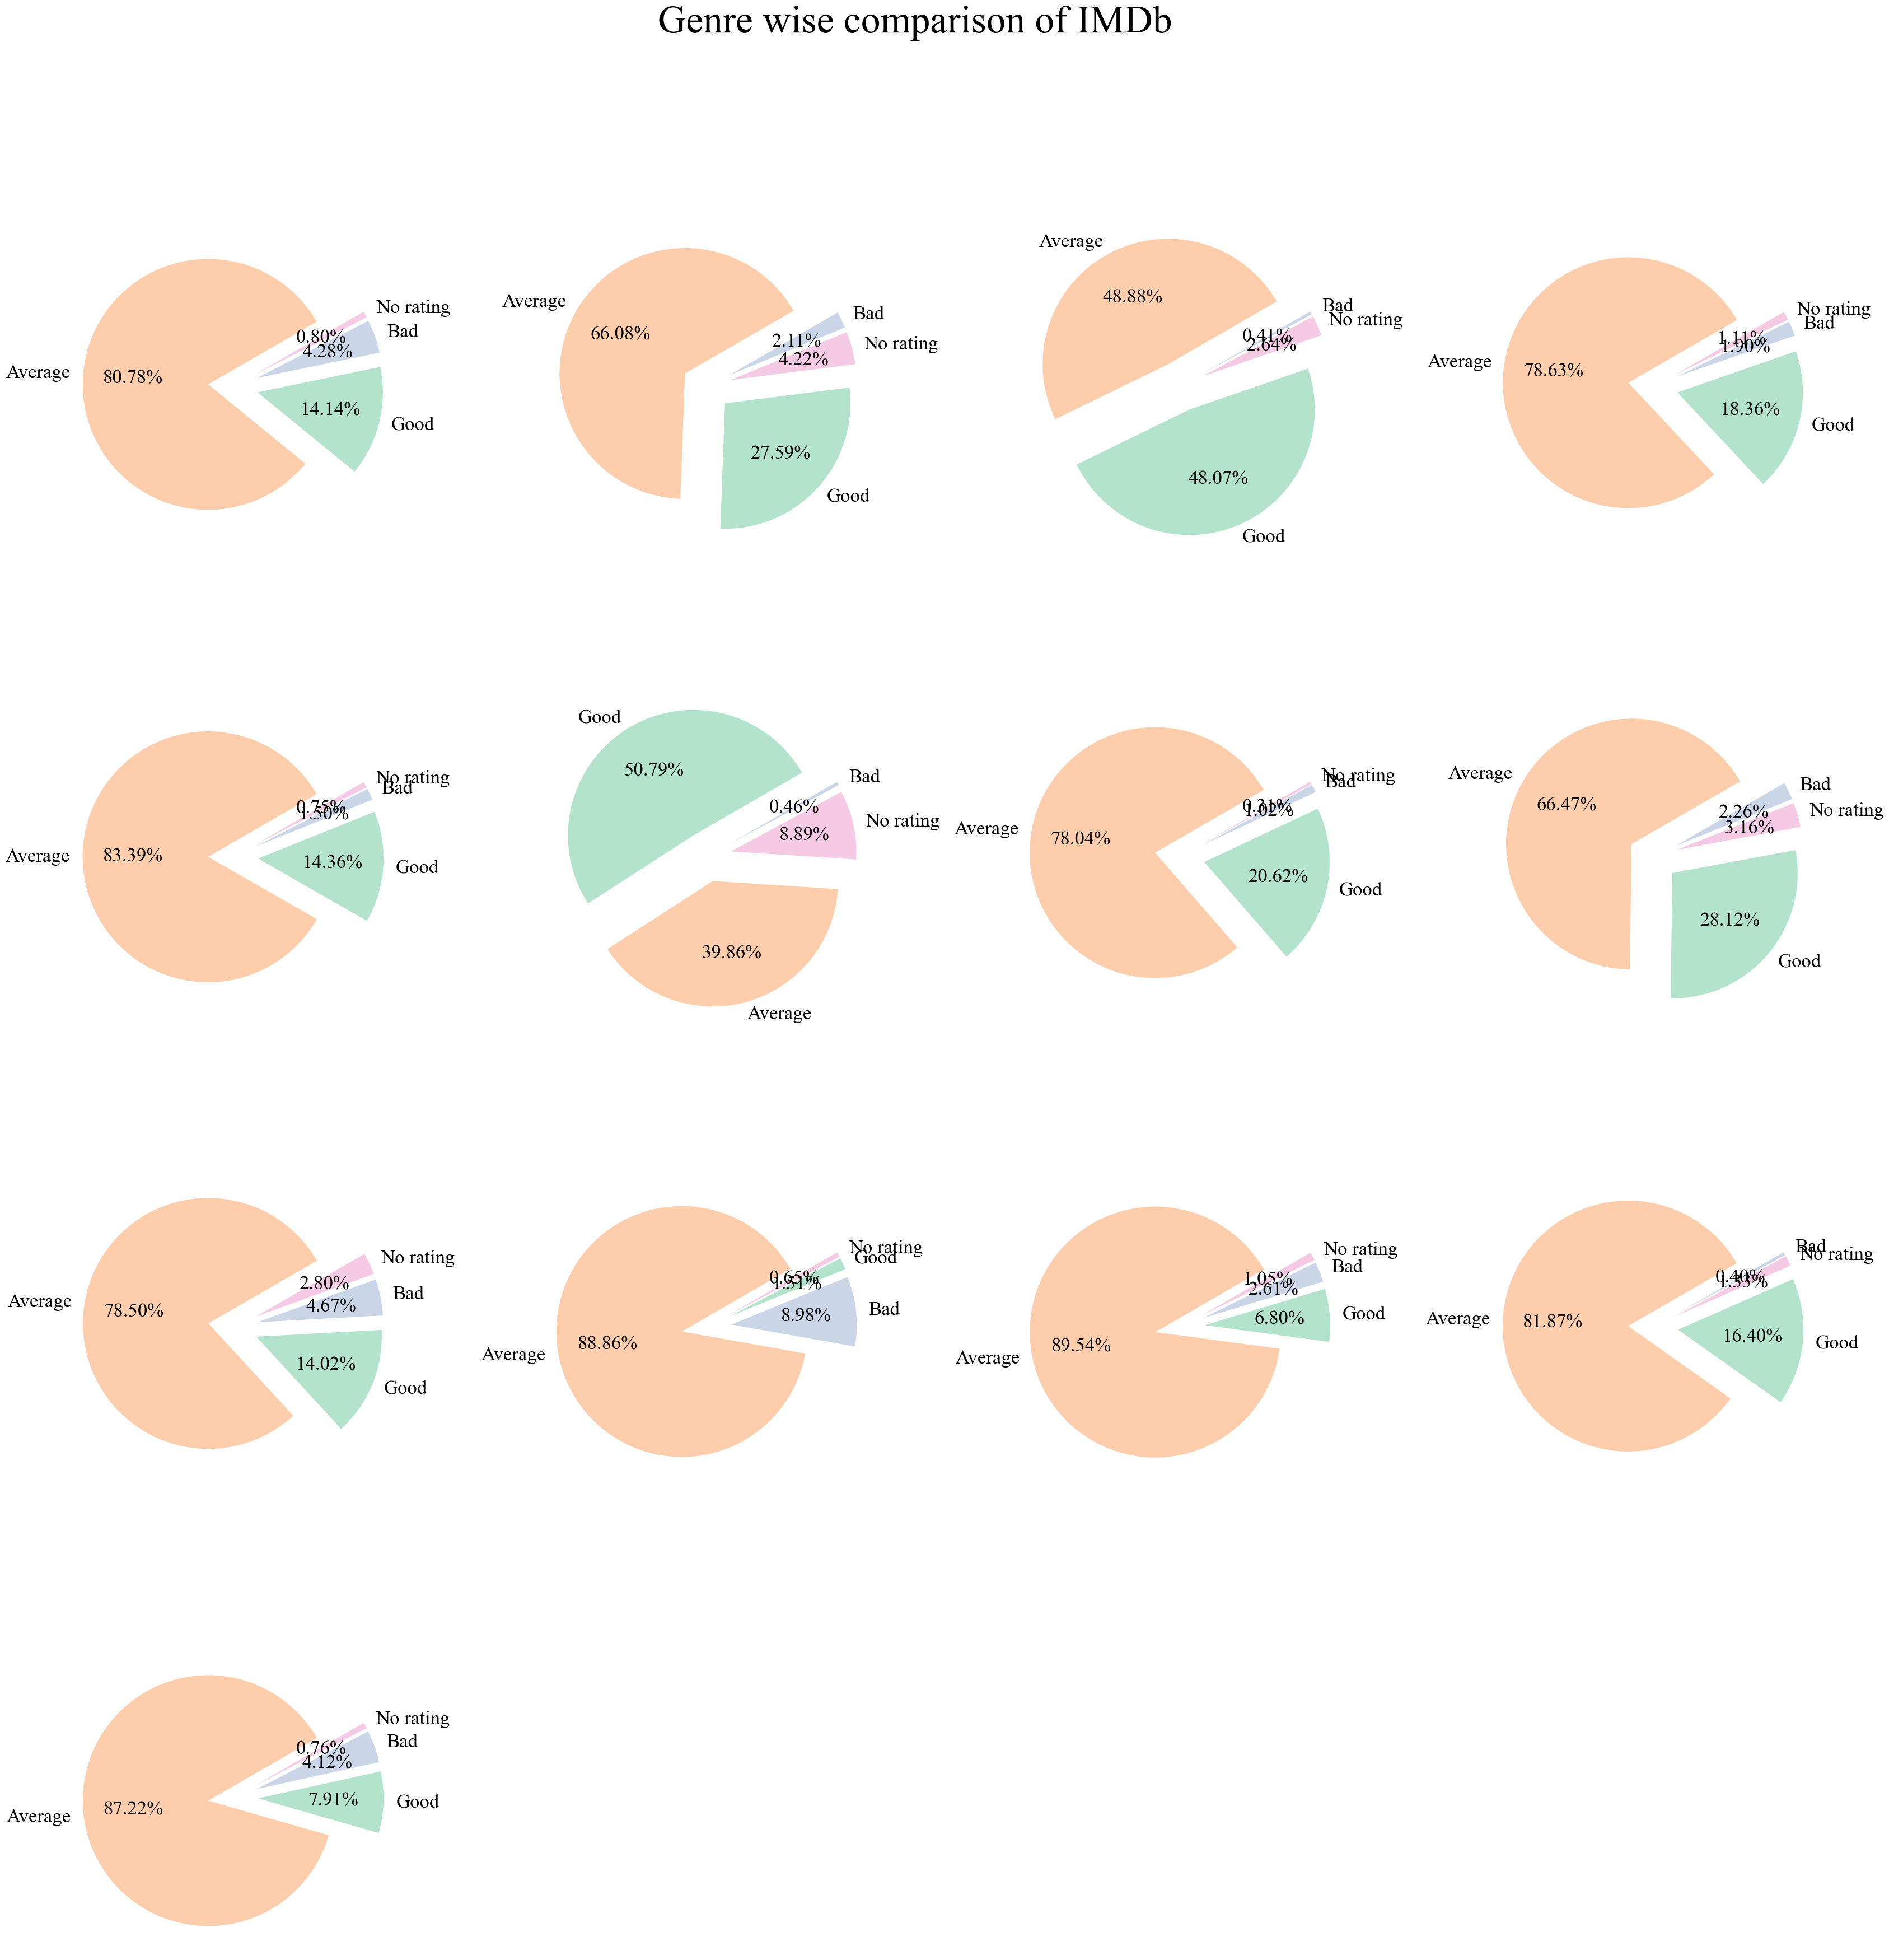

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data by Genre and Category of IMDb
genre_grouped_projectdata = projectdata.groupby("Genre").apply(lambda x: x['Category of IMDb'].value_counts())
genre_grouped_projectdata = genre_grouped_projectdata.reset_index()
genre_grouped_projectdata.rename(columns={"Category of IMDb": "Frequency", "level_1": "Category of IMDb"}, inplace=True)

fig, axes = plt.subplots(4, 4, figsize=(40, 40))
[axi.set_axis_off() for axi in axes.ravel()]
plt.subplots_adjust(wspace=0.5, hspace=0.5)


fig.suptitle('Genre wise comparison of IMDb', fontsize=50)

kwargs = dict(startangle=30,
    fontsize=25,
    autopct='%1.2f%%')

IMDb_category_colors = {
    "Good": plt.cm.Pastel2(0),
    "Average": plt.cm.Pastel2(1),
    "Bad": plt.cm.Pastel2(2),
    "No rating": plt.cm.Pastel2(3),
}


for idx, genre in enumerate(projectdata['Genre'].unique()):
    genre_data = projectdata[projectdata['Genre'] == genre]
    genre_IMDb_category_count = genre_data['Category of IMDb'].value_counts()
    i, j = [idx//4, idx%4]
    
    kwargs['explode'] = [0.2]*len(genre_IMDb_category_count)
    kwargs['colors'] = [IMDb_category_colors[index] for index in genre_IMDb_category_count.index]
    genre_IMDb_category_count.plot.pie(ax=axes[i, j] ,**kwargs)
#    axes[i, j].set_title(genre, fontsize=30)

In [207]:
#Correlation 

merged_genre_data.head()

,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video,Category of Rotten Tomatoes,Category of IMDb
0,Terminator: Dark Fate,2019,18,6.2,81.0,Action & Adventure,0,1,Fresh,Average
1,Gemini Man,2019,13,5.7,74.0,Action & Adventure,0,1,Fresh,Average
2,Rambo: Last Blood,2019,18,6.1,72.0,Action & Adventure,0,1,Fresh,Average
3,The Courier,2019,18,4.9,50.0,Action & Adventure,0,1,Rotten,Average
4,Crawl,2019,18,6.1,79.0,Action & Adventure,0,1,Fresh,Average


In [208]:
IMDb=merged_genre_data['IMDb']
Rotten_Tomatoes=merged_genre_data['Rotten Tomatoes']
Netflix=merged_genre_data['Netflix']
Amazon_Prime_Video=merged_genre_data['Amazon Prime Video']

                        IMDb  Rotten Tomatoes   Netflix  Amazon Prime Video
IMDb                1.000000         0.481964  0.123075           -0.118046
Rotten Tomatoes     0.481964         1.000000  0.275702           -0.270444
Netflix             0.123075         0.275702  1.000000           -0.970047
Amazon Prime Video -0.118046        -0.270444 -0.970047            1.000000


Text(0.5, 1.0, 'Correlation-Ratings and Streaming Platforms')

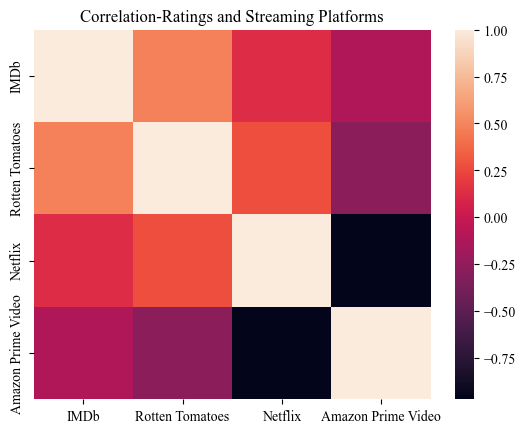

In [209]:
selected_cols = ['IMDb', 'Rotten Tomatoes' , 'Netflix' , 'Amazon Prime Video']
merged_genre_data_selected = merged_genre_data[selected_cols]
sns.heatmap(merged_genre_data_selected.corr())
print(merged_genre_data_selected.corr())
plt.title("Correlation-Ratings and Streaming Platforms")

In [323]:
#Regression

#Converting Genre categorical variable using dummy coding to use in regression analysis
genres = list(projectdata["Genre"].unique())

def populate_genre(row):
    for genre in row["Genre"].strip().split(','):
        row[genre]=1
    return row

for genre in genres:
    merged_genre_data[genre] = 0
    
merged_genre_data = merged_genre_data.apply(lambda row: populate_genre(row), axis=1)
merged_genre_data.tail()

,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video,Category of Rotten Tomatoes,Category of IMDb,...,Comedy,Crime,Documentary,Drama,Family,Fantasy,Horror,Mystery,Romance,Thriller
15233,Splatter,2015,NaN,3.1,31.0,Drama,1,0,Rotten,Average,...,0,0,0,1,0,0,0,0,0,0
15234,The Ant's Scream,2011,NaN,6.3,33.0,Drama,1,0,Rotten,Average,...,0,0,0,1,0,0,0,0,0,0
15235,Mama's Boy,2018,NaN,4.9,33.0,Drama,1,0,Rotten,Average,...,0,0,0,1,0,0,0,0,0,0
15236,I Am Jonas,2018,NaN,7.0,52.0,Drama,1,0,Rotten,Good,...,0,0,0,1,0,0,0,0,0,0
15237,BlackRose,2018,NaN,NaN,NaN,Drama,1,0,No Tomatometer,No rating,...,0,0,0,1,0,0,0,0,0,0


In [324]:
# Linear regression predicting IMDb and Rotten Tomatoes rating from genre, netflix, and Amazon Prime Video

import statsmodels.api as sm

merged_genre_data_no_na = merged_genre_data.dropna()
x = merged_genre_data_no_na[genres + ['Amazon Prime Video', 'Netflix']]   # independent variable
y = merged_genre_data_no_na['Rotten Tomatoes']  # dependent variable

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Rotten Tomatoes   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              5063.
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                        0.00
Time:                        15:25:45   Log-Likelihood:                         -24884.
No. Observations:                6156   AIC:                                  4.980e+04
Df Residuals:                    6141   BIC:                                  4.990e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Action & Adventure     1.6370      0.433      3.783      0.000       0.789       2.485
Animation             -0.1052      0.890     -0.118      0.906      -1.850       1.640
Biography              3.3274      1.247      2.668      0.008       0.883       5.772
Comedy                 0.3567      0.426      0.836      0.403      -0.479       1.193
Crime                 -4.6153      0.591     -7.815      0.000      -5.773      -3.458
Documentary           -4.1070      0.740     -5.547      0.000      -5.558      -2.656
Drama                  5.1982      0.417     12.455      0.000       4.380       6.016
Family                -7.6762      0.965     -7.954      0.000      -9.568      -5.784
Fantasy               -4.3494      2.635     -1.651      0.099      -9.515       0.816
Horror                -7.1512      0.695    -10.287      0.000      -8.514      -5.788
Mystery               -2.2306      1.021     -2.186      0.029      -4.231      -0.230
Romance               -6.5840      1.255     -5.245      0.000      -9.045      -4.123
Thriller              -6.6958      0.811     -8.253      0.000      -8.286      -5.105
Amazon Prime Video    44.9224      0.485     92.611      0.000      43.972      45.873
Netflix               53.3171      0.562     94.827      0.000      52.215      54.419
==============================================================================
Omnibus:                      161.251   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              393.500
Skew:                           0.021   Prob(JB):                     3.57e-86
Kurtosis:                       4.238   Cond. No.                         16.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [325]:
pd.DataFrame({
    'Actual Rotten Tomatoes': y,
    'Predicted Rotten Tomatoes': model.predict(x)
})

,Actual Rotten Tomatoes,Predicted Rotten Tomatoes
0,81.0,46.559435
1,74.0,46.559435
2,72.0,46.559435
3,50.0,46.559435
4,79.0,46.559435
...,...,...
15171,38.0,58.515270
15182,39.0,58.515270
15186,27.0,58.515270
15194,42.0,58.515270


In [326]:
merged_genre_data_no_na = merged_genre_data.dropna()
x = merged_genre_data_no_na[genres + ['Amazon Prime Video', 'Netflix']]   # independent variable
y = merged_genre_data_no_na['IMDb']   # dependent variable

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   IMDb   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              9009.
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                        0.00
Time:                        15:25:45   Log-Likelihood:                         -10025.
No. Observations:                6156   AIC:                                  2.008e+04
Df Residuals:                    6141   BIC:                                  2.018e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Action & Adventure    -0.0612      0.039     -1.581      0.114      -0.137       0.015
Animation              0.4715      0.080      5.919      0.000       0.315       0.628
Biography              0.5971      0.112      5.352      0.000       0.378       0.816
Comedy                 0.1805      0.038      4.729      0.000       0.106       0.255
Crime                 -0.0860      0.053     -1.627      0.104      -0.190       0.018
Documentary            1.5249      0.066     23.020      0.000       1.395       1.655
Drama                  0.6273      0.037     16.800      0.000       0.554       0.701
Family                 0.2220      0.086      2.571      0.010       0.053       0.391
Fantasy                0.1243      0.236      0.527      0.598      -0.338       0.586
Horror                -0.7957      0.062    -12.793      0.000      -0.918      -0.674
Mystery               -0.0188      0.091     -0.206      0.837      -0.198       0.160
Romance                0.2343      0.112      2.086      0.037       0.014       0.454
Thriller              -0.2465      0.073     -3.396      0.001      -0.389      -0.104
Amazon Prime Video     5.1951      0.043    119.701      0.000       5.110       5.280
Netflix                5.6093      0.050    111.500      0.000       5.511       5.708
==============================================================================
Omnibus:                     1082.040   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3117.242
Skew:                          -0.926   Prob(JB):                         0.00
Kurtosis:                       5.953   Cond. No.                         16.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [327]:
pd.DataFrame({
    'Actual IMDb': y,
    'Predicted IMDb': model.predict(x)
})

,Actual IMDb,Predicted IMDb
0,6.2,5.133895
1,5.7,5.133895
2,6.1,5.133895
3,4.9,5.133895
4,6.1,5.133895
...,...,...
15171,6.1,6.236594
15182,5.8,6.236594
15186,5.7,6.236594
15194,7.3,6.236594


In [328]:
# Linear regression predicting IMDb and Rotten Tomatoes rating from Netflix and Amazon Prime Video

import statsmodels.api as sm

merged_genre_data_no_na = merged_genre_data.dropna()
x = merged_genre_data_no_na['IMDb']   # independent variable
y = merged_genre_data_no_na['Rotten Tomatoes']  # dependent variable

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Rotten Tomatoes   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                          1.079e+05
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                        0.00
Time:                        15:25:46   Log-Likelihood:                         -23878.
No. Observations:                6156   AIC:                                  4.776e+04
Df Residuals:                    6155   BIC:                                  4.777e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
IMDb           8.2861      0.025    328.522      0.000       8.237       8.336
==============================================================================
Omnibus:                       51.100   Durbin-Watson:                   0.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.590
Skew:                          -0.155   Prob(JB):                     2.08e-10
Kurtosis:                       2.722   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [329]:
pd.DataFrame({
    'Actual Rotten Tomatoes': y,
    'Predicted Rotten Tomatoes': model.predict(x)
})

,Actual Rotten Tomatoes,Predicted Rotten Tomatoes
0,81.0,51.374029
1,74.0,47.230962
2,72.0,50.545416
3,50.0,40.602055
4,79.0,50.545416
...,...,...
15171,38.0,50.545416
15182,39.0,48.059575
15186,27.0,47.230962
15194,42.0,60.488776


Text(0.5, 1.0, 'Impact of Rotten Tomatoes based on IMDb in overall database')

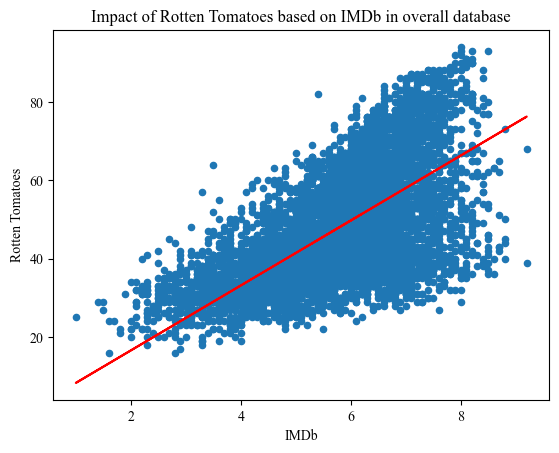

In [339]:
merged_genre_data_no_na.plot.scatter("IMDb", "Rotten Tomatoes",)

plt.plot(x, model.params[0]*x, color='red')
plt.title("Impact of Rotten Tomatoes based on IMDb in overall database")

In [340]:
#Netflix data - Rotten tomatoes as dependent variable
netflix_data_no_na = netflix_data.dropna()
x = netflix_data_no_na['IMDb']   # independent variable
y = netflix_data_no_na['Rotten Tomatoes']  # dependent variable

modelnetflix = sm.OLS(y, x).fit()
modelnetflix.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Rotten Tomatoes   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                          3.303e+04
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                        0.00
Time:                        16:39:35   Log-Likelihood:                         -5154.9
No. Observations:                1329   AIC:                                  1.031e+04
Df Residuals:                    1328   BIC:                                  1.032e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
IMDb           9.1749      0.050    181.749      0.000       9.076       9.274
==============================================================================
Omnibus:                       79.374   Durbin-Watson:                   1.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.070
Skew:                          -0.319   Prob(JB):                     6.01e-11
Kurtosis:                       2.334   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [341]:
pd.DataFrame({
    'Actual Rotten Tomatoes': y,
    'Predicted Rotten Tomatoes': modelnetflix.predict(x)
})

,Actual Rotten Tomatoes,Predicted Rotten Tomatoes
46,73.0,64.224139
50,53.0,52.296799
159,62.0,66.059114
264,46.0,51.379311
588,93.0,73.399016
...,...,...
15171,38.0,55.966750
15182,39.0,53.214287
15186,27.0,52.296799
15194,42.0,66.976602


Text(0.5, 1.0, 'Impact of Rotten Tomatoes based on IMDb in Netflix')

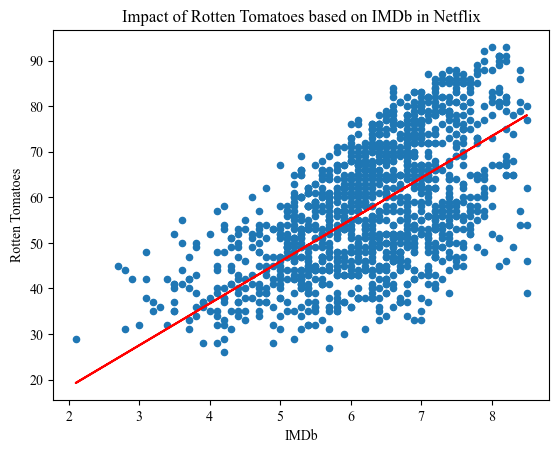

In [343]:
netflix_data_no_na.plot.scatter("IMDb", "Rotten Tomatoes",)

plt.plot(x, modelnetflix.params[0]*x, color='red')
plt.title("Impact of Rotten Tomatoes based on IMDb in Netflix")

In [334]:
#Amazon Prime Video data
amazon_prime_video_data_no_na = amazon_prime_video_data.dropna()
x = amazon_prime_video_data_no_na['IMDb']   # independent variable
y = amazon_prime_video_data_no_na['Rotten Tomatoes']  # dependent variable

modelamazonprimevideo = sm.OLS(y, x).fit()
modelamazonprimevideo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Rotten Tomatoes   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                          8.367e+04
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                        0.00
Time:                        15:25:55   Log-Likelihood:                         -18726.
No. Observations:                4884   AIC:                                  3.745e+04
Df Residuals:                    4883   BIC:                                  3.746e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
IMDb           7.9965      0.028    289.257      0.000       7.942       8.051
==============================================================================
Omnibus:                       25.508   Durbin-Watson:                   1.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.307
Skew:                          -0.145   Prob(JB):                     5.27e-06
Kurtosis:                       2.812   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [335]:
pd.DataFrame({
    'Actual Rotten Tomatoes': y,
    'Predicted Rotten Tomatoes': modelamazonprimevideo.predict(x)
})

,Actual Rotten Tomatoes,Predicted Rotten Tomatoes
0,81.0,49.578239
1,74.0,45.579994
2,72.0,48.778590
3,50.0,39.182801
4,79.0,48.778590
...,...,...
12569,41.0,53.576484
12571,33.0,42.381398
12573,30.0,39.182801
12588,39.0,54.376133


Text(0.5, 1.0, 'Impact of Rotten Tomatoes based on IMDb in Amazon Prime Video')

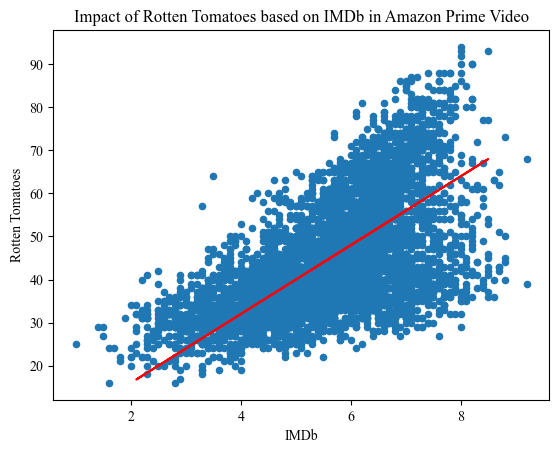

In [344]:
amazon_prime_video_data_no_na.plot.scatter("IMDb", "Rotten Tomatoes")

plt.plot(x, modelamazonprimevideo.params[0]*x, color='red')
plt.title("Impact of Rotten Tomatoes based on IMDb in Amazon Prime Video")

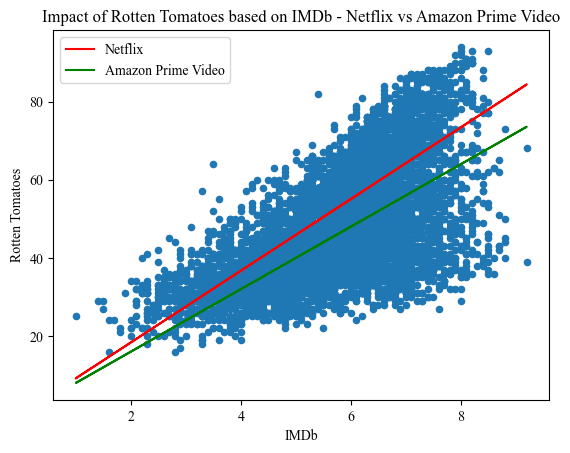

In [337]:
#Multple regression in same plot

from matplotlib.lines import Line2D

merged_genre_data_no_na = merged_genre_data.dropna()
merged_genre_data_no_na.plot.scatter("IMDb", "Rotten Tomatoes")
x = merged_genre_data_no_na["IMDb"]
y = merged_genre_data_no_na["Rotten Tomatoes"]
plt.plot(x, modelamazonprimevideo.params[0]*x, color='green')
plt.plot(x, modelnetflix.params[0]*x, color='red')

plt.title("Impact of Rotten Tomatoes based on IMDb - Netflix vs Amazon Prime Video")
handles, labels = plt.gca().get_legend_handles_labels()
line1 = Line2D([0], [0], label='Netflix', color='red')
line2 = Line2D([0], [0], label='Amazon Prime Video', color='green')
handles.extend([line1, line2])
plt.legend(handles=handles)



In [347]:
#Actual value and the predicted value
actualvspredictvalue = pd.DataFrame({
    'IMDb': x,
    'Actual value of Rotten Tomatoes': y, 
    'Netflix': modelnetflix.params[0]*x, 
    'Amazon Prime Video':modelamazonprimevideo.params[0]*x
})
actualvspredictvalue.head()

,IMDb,Actual value of Rotten Tomatoes,Netflix,Amazon Prime Video
46,7.0,73.0,64.224139,55.975431
50,5.7,53.0,52.296799,45.579994
159,7.2,62.0,66.059114,57.574729
264,5.6,46.0,51.379311,44.780345
588,8.0,93.0,73.399016,63.971921
